In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_hybrid_renaissance_cv'
context = 500
corpora = tuple(['bach.chorales','orto','dufay','ockeghem','josquin','rue'])

In [3]:
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 1 # window with which we scan over time
        self.k = k = 500
        self.wnotes = Parameter(Tensor(64, 1, self.kernel_width,6,self.m//2))
        self.wnotes2 = Parameter(Tensor(k, 64, self.kernel_width))
        self.wdur = Parameter(Tensor(k, 6*self.maxdur, self.kernel_width))
        self.wtop = Parameter(Tensor(k, self.composers))
        
        self.km = km = 300
        
        self.wnotesm = Parameter(Tensor(km, self.m, 1, 3))
        self.wdurationm = Parameter(Tensor(km, self.maxdur, 1, 3))
        self.w2m = Parameter(Tensor(km, km, 1, 3))
        self.wtopm = Parameter(Tensor(km, self.composers))
        
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        zn1 = F.relu(F.conv3d(e.view(batch_size*3,1,context,6,self.m),self.wnotes)).sum(4)
        z1 = F.relu(F.conv1d(zn1.transpose(2,3).contiguous().view(batch_size*3,64,-1),self.wnotes2) \
           + F.conv1d(t.transpose(2,4).contiguous().view(batch_size*3,self.maxdur*6,-1),self.wdur))
        z1 = z1.view(batch_size,3,self.k,context).mean(1).mean(2)
        
        z1m = F.relu(F.conv2d(e.view(batch_size*3,context,6,self.m).transpose(1,3),self.wnotesm) \
            + F.conv2d(t.view(batch_size*3,context,6,self.maxdur).transpose(1,3),self.wdurationm))
        z2m = F.relu(F.conv2d(z1m,self.w2m))
        z2m = z2m.view(batch_size,3,self.km,-1).mean(1).mean(2)
        
        return torch.mm(z1, self.wtop) \
             + torch.mm(z2m, self.wtopm) \
             + self.bias[None,:].expand(e.shape[0],-1)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
3.00    2.68    0       5.83    5.89    5.19    4.29    
57.00   56.25   29      2.35    2.33    9.69    3.57    
64.00   64.29   58      1.84    2.04    9.67    3.35    
66.00   65.18   87      1.65    1.70    9.40    3.

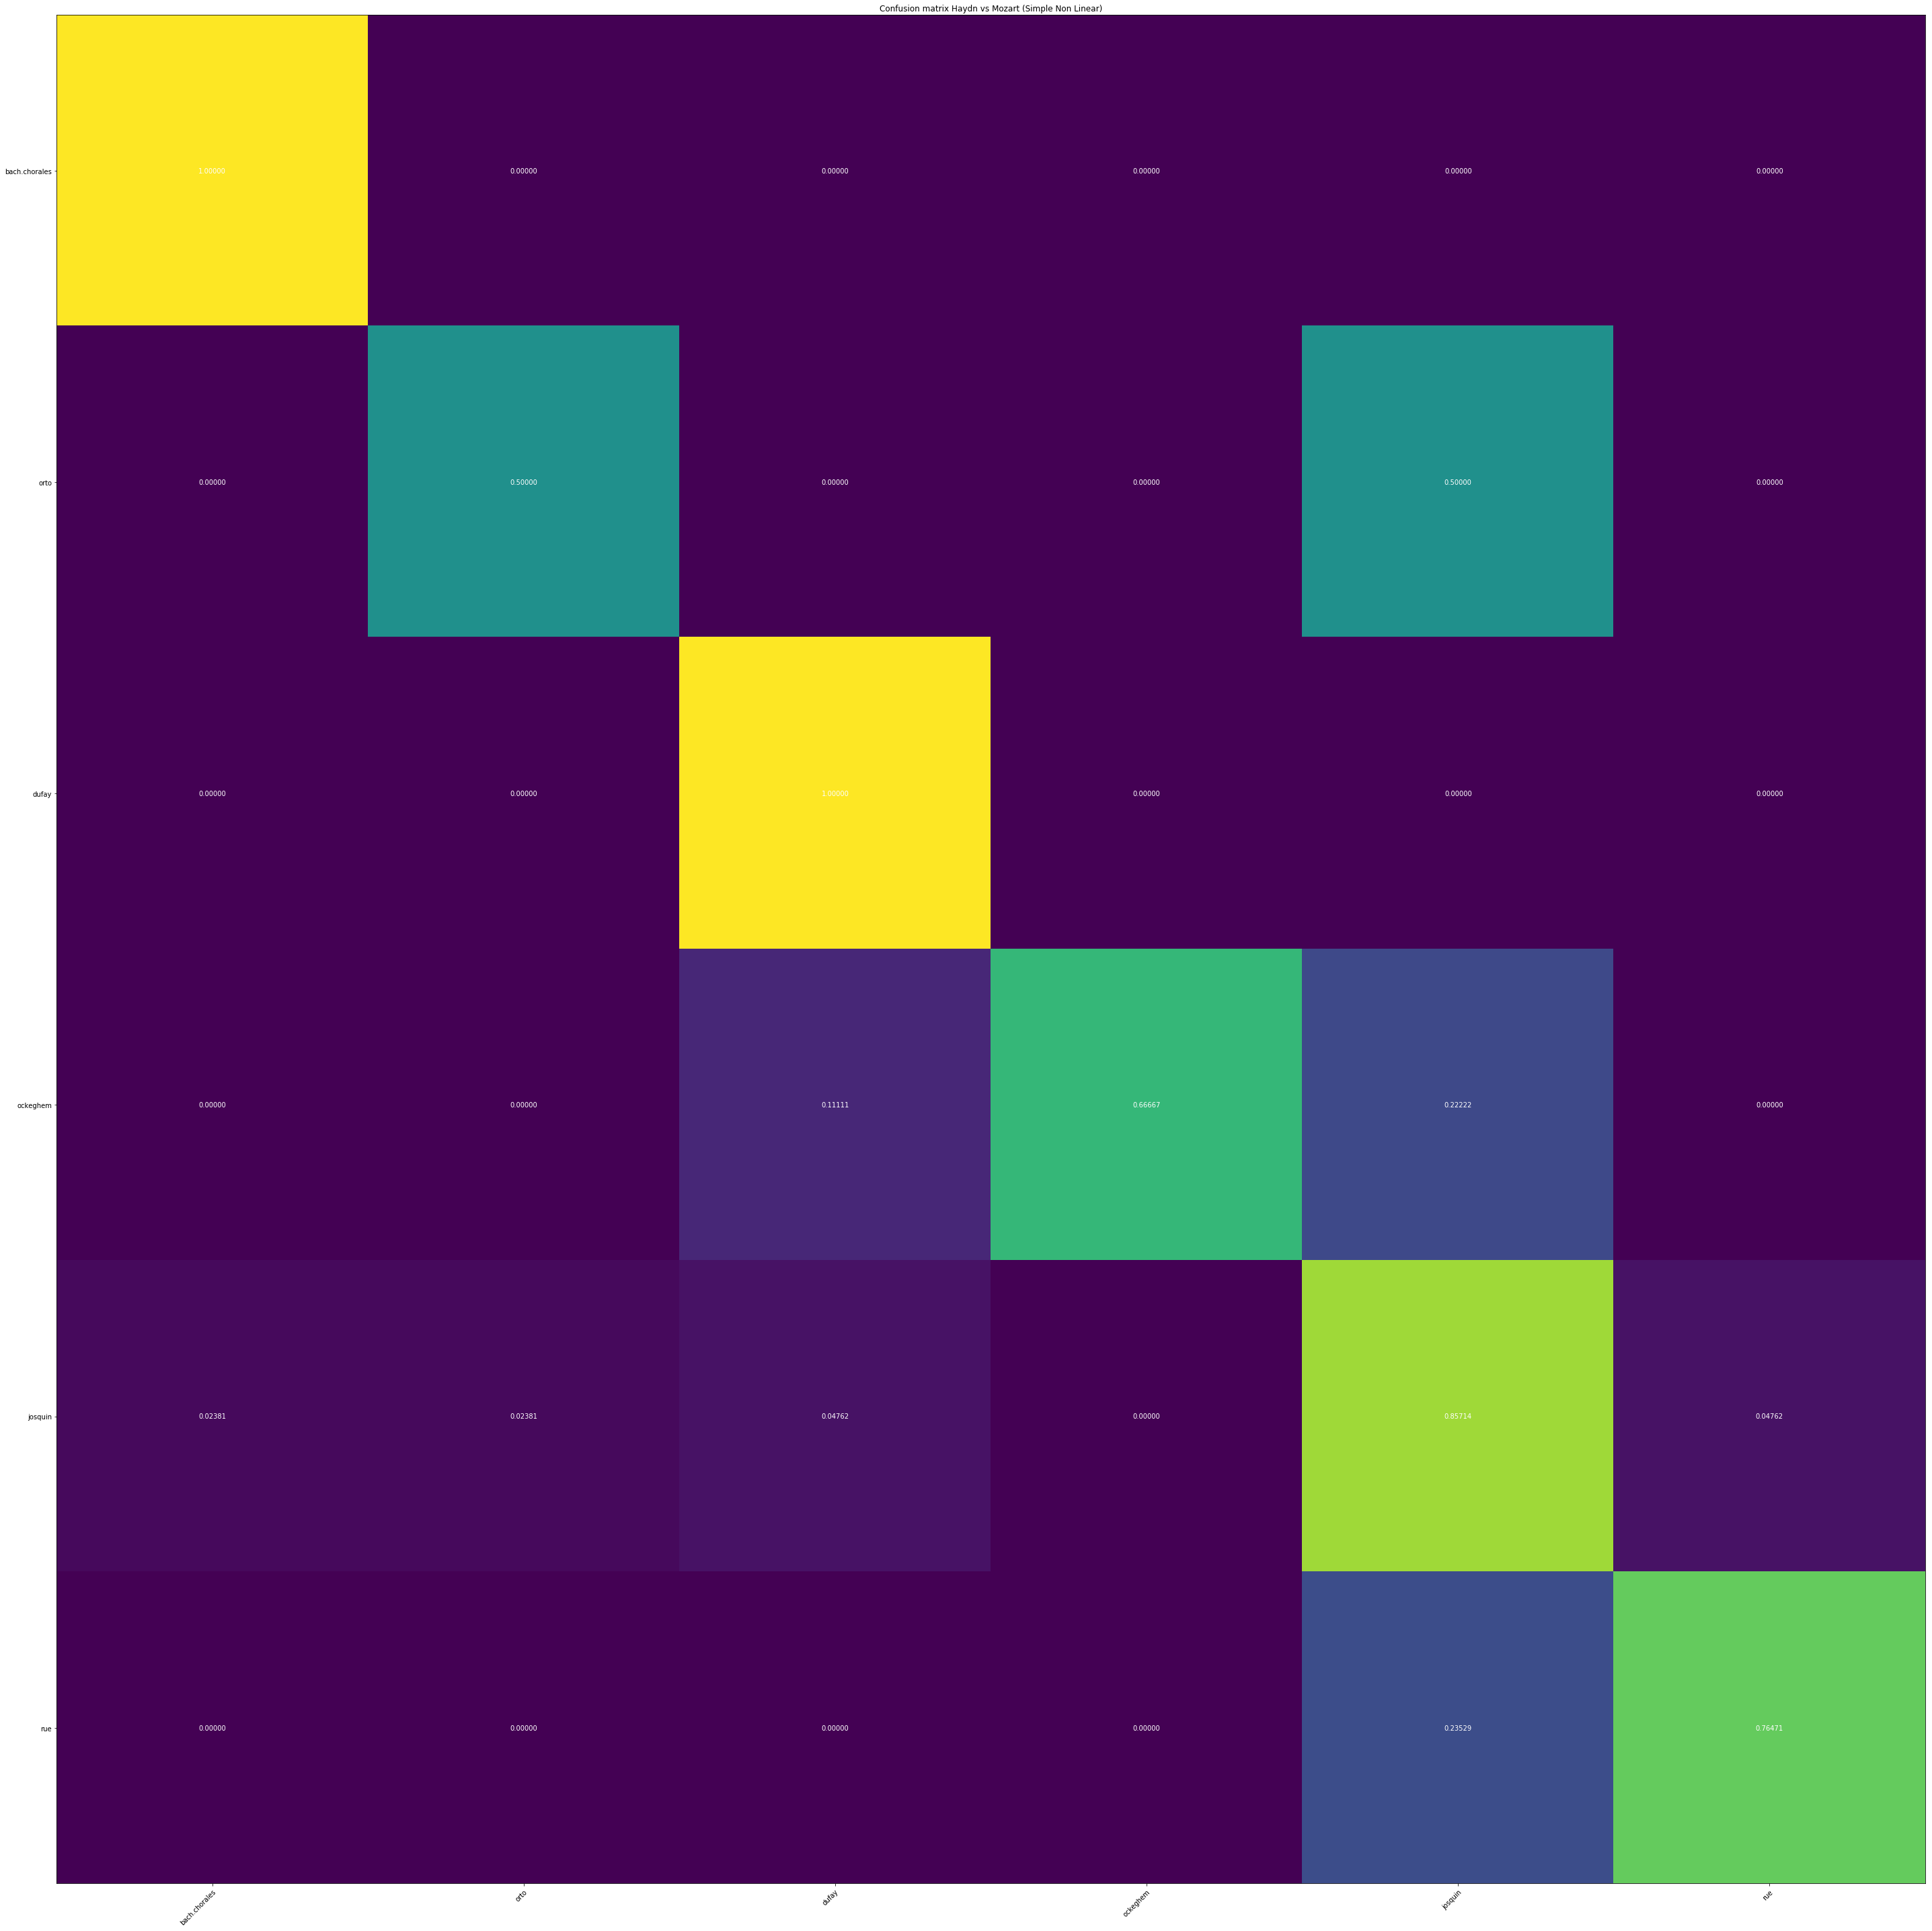

bach.chorales 37 / 37 = 1.0
dufay 3 / 3 = 1.0
josquin 36 / 42 = 0.8571428571428571
ockeghem 6 / 9 = 0.6666666666666666
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
97 112 0.8660714285714286
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
6.00    6.25    0       4.

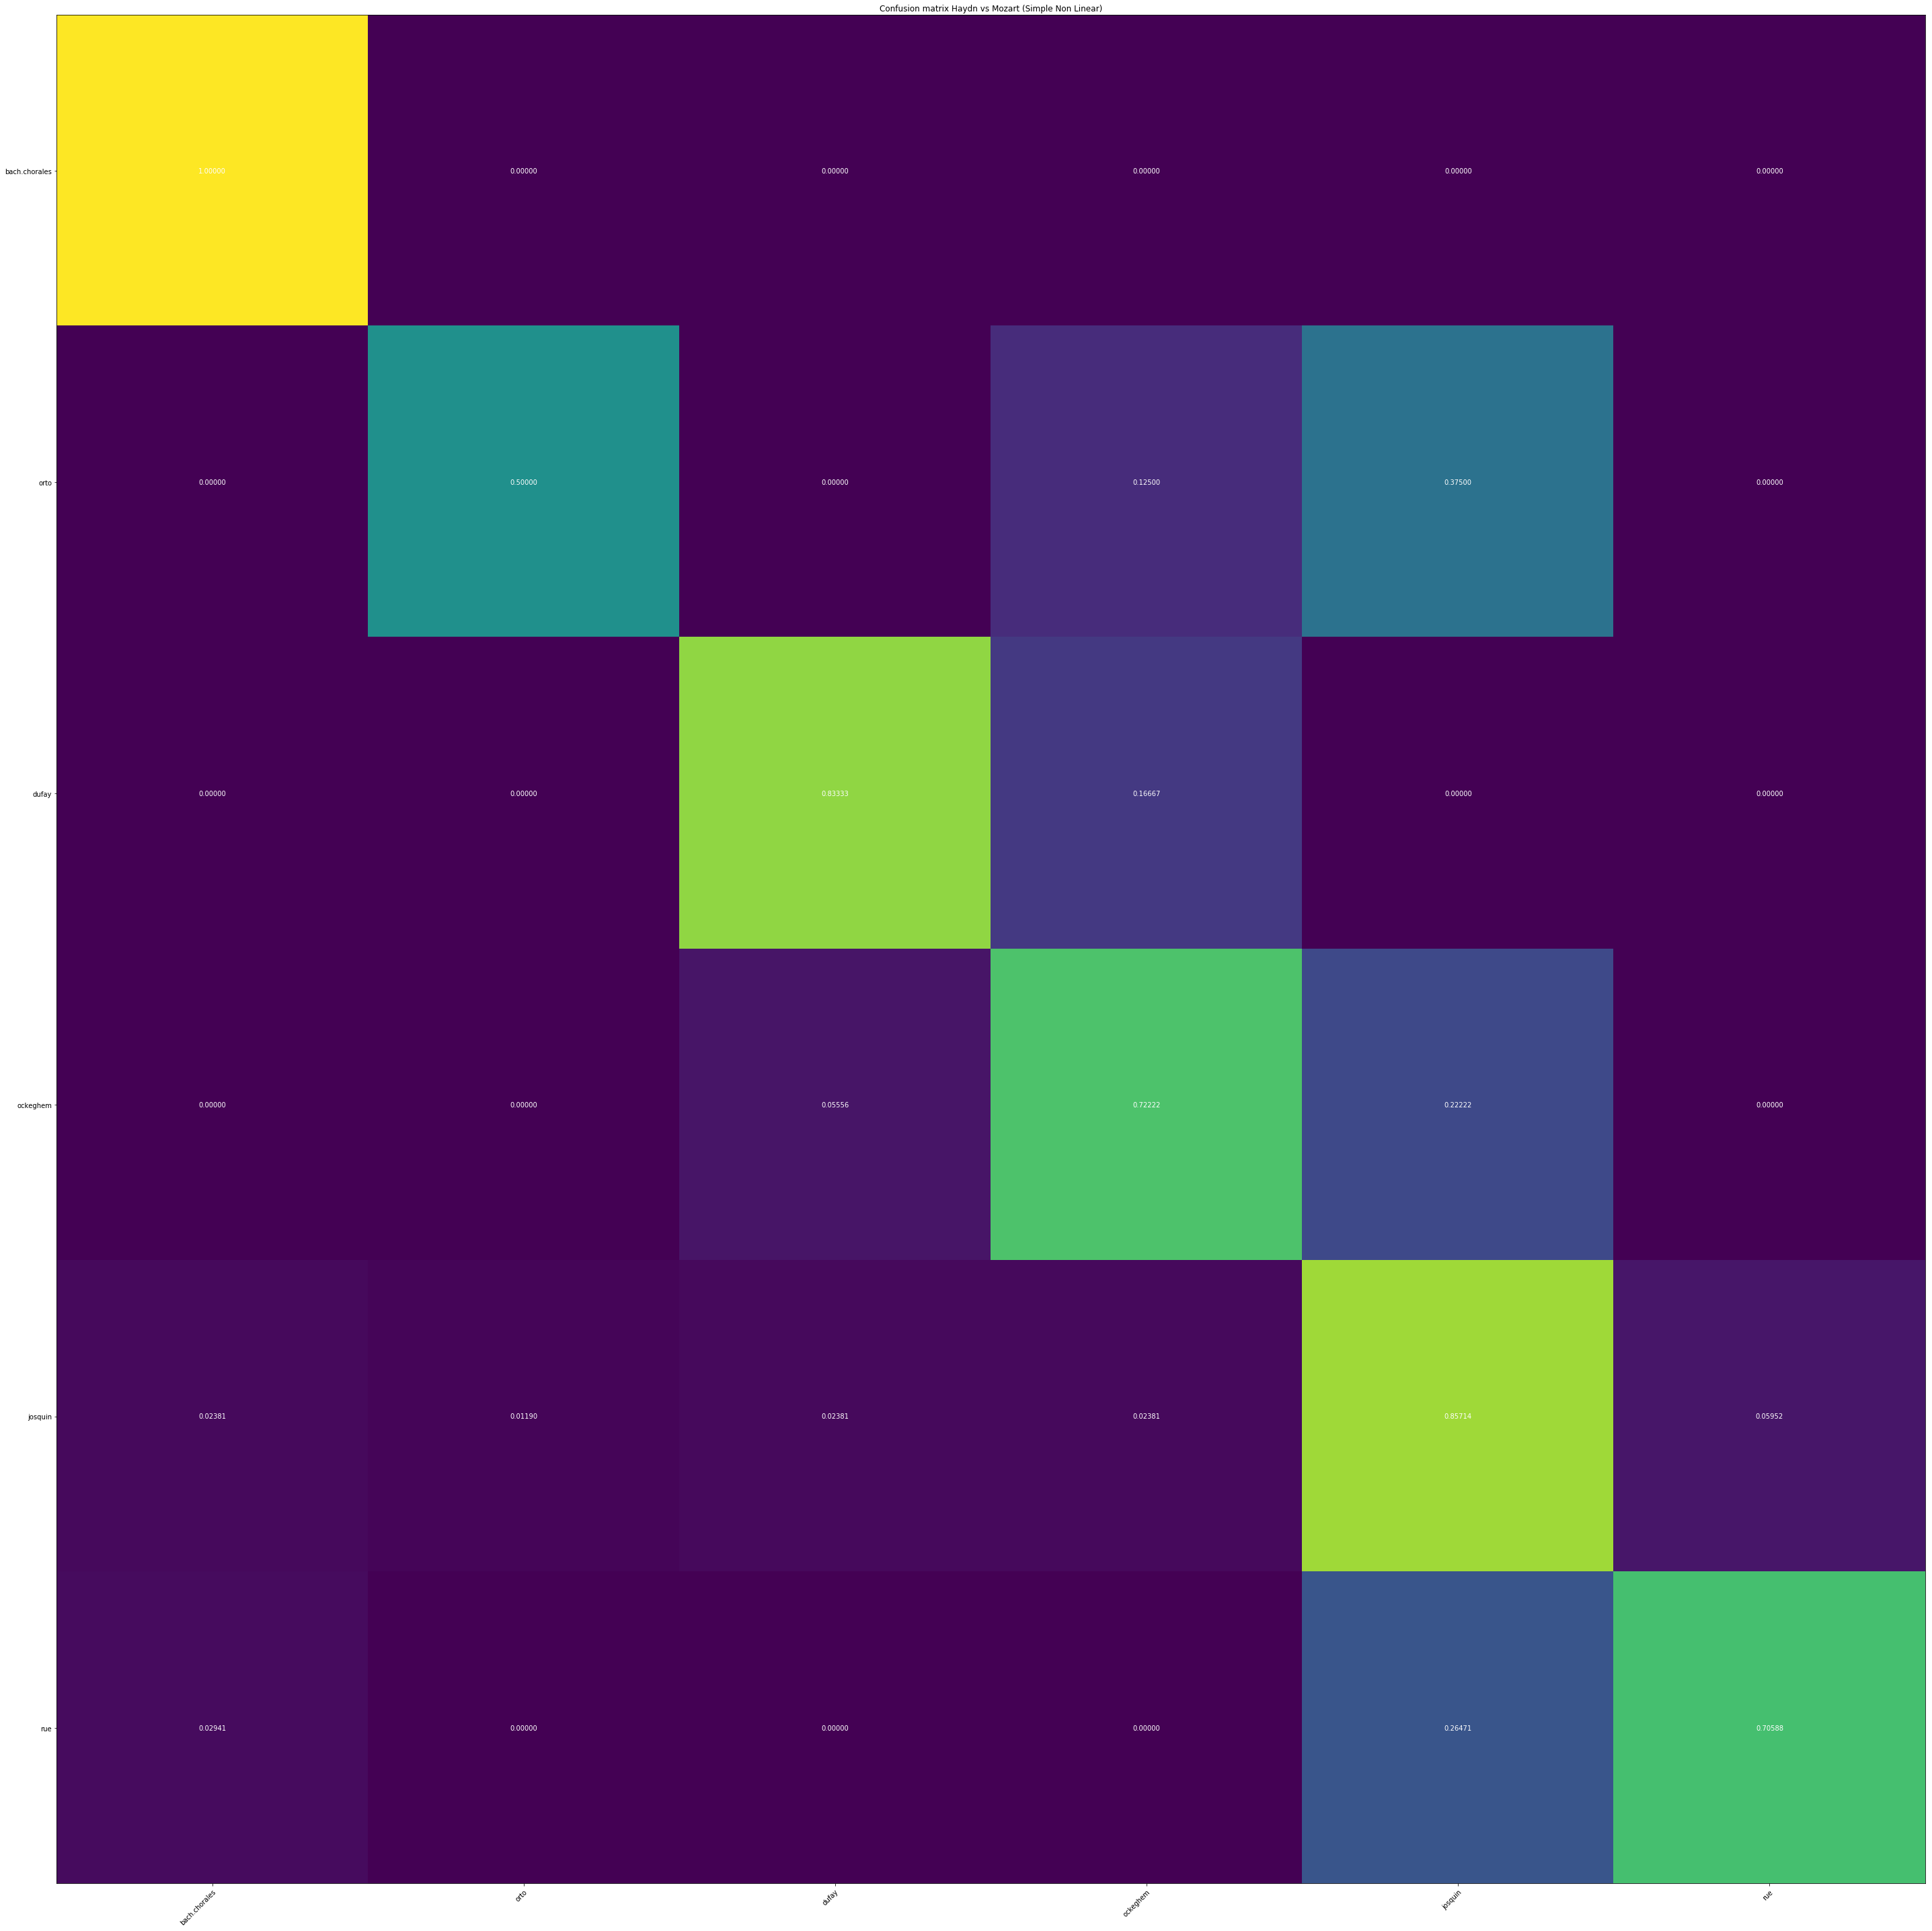

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 36 / 42 = 0.8571428571428571
ockeghem 7 / 9 = 0.7777777777777778
orto 2 / 4 = 0.5
rue 11 / 17 = 0.6470588235294118
95 112 0.8482142857142857
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
1.50    3.5

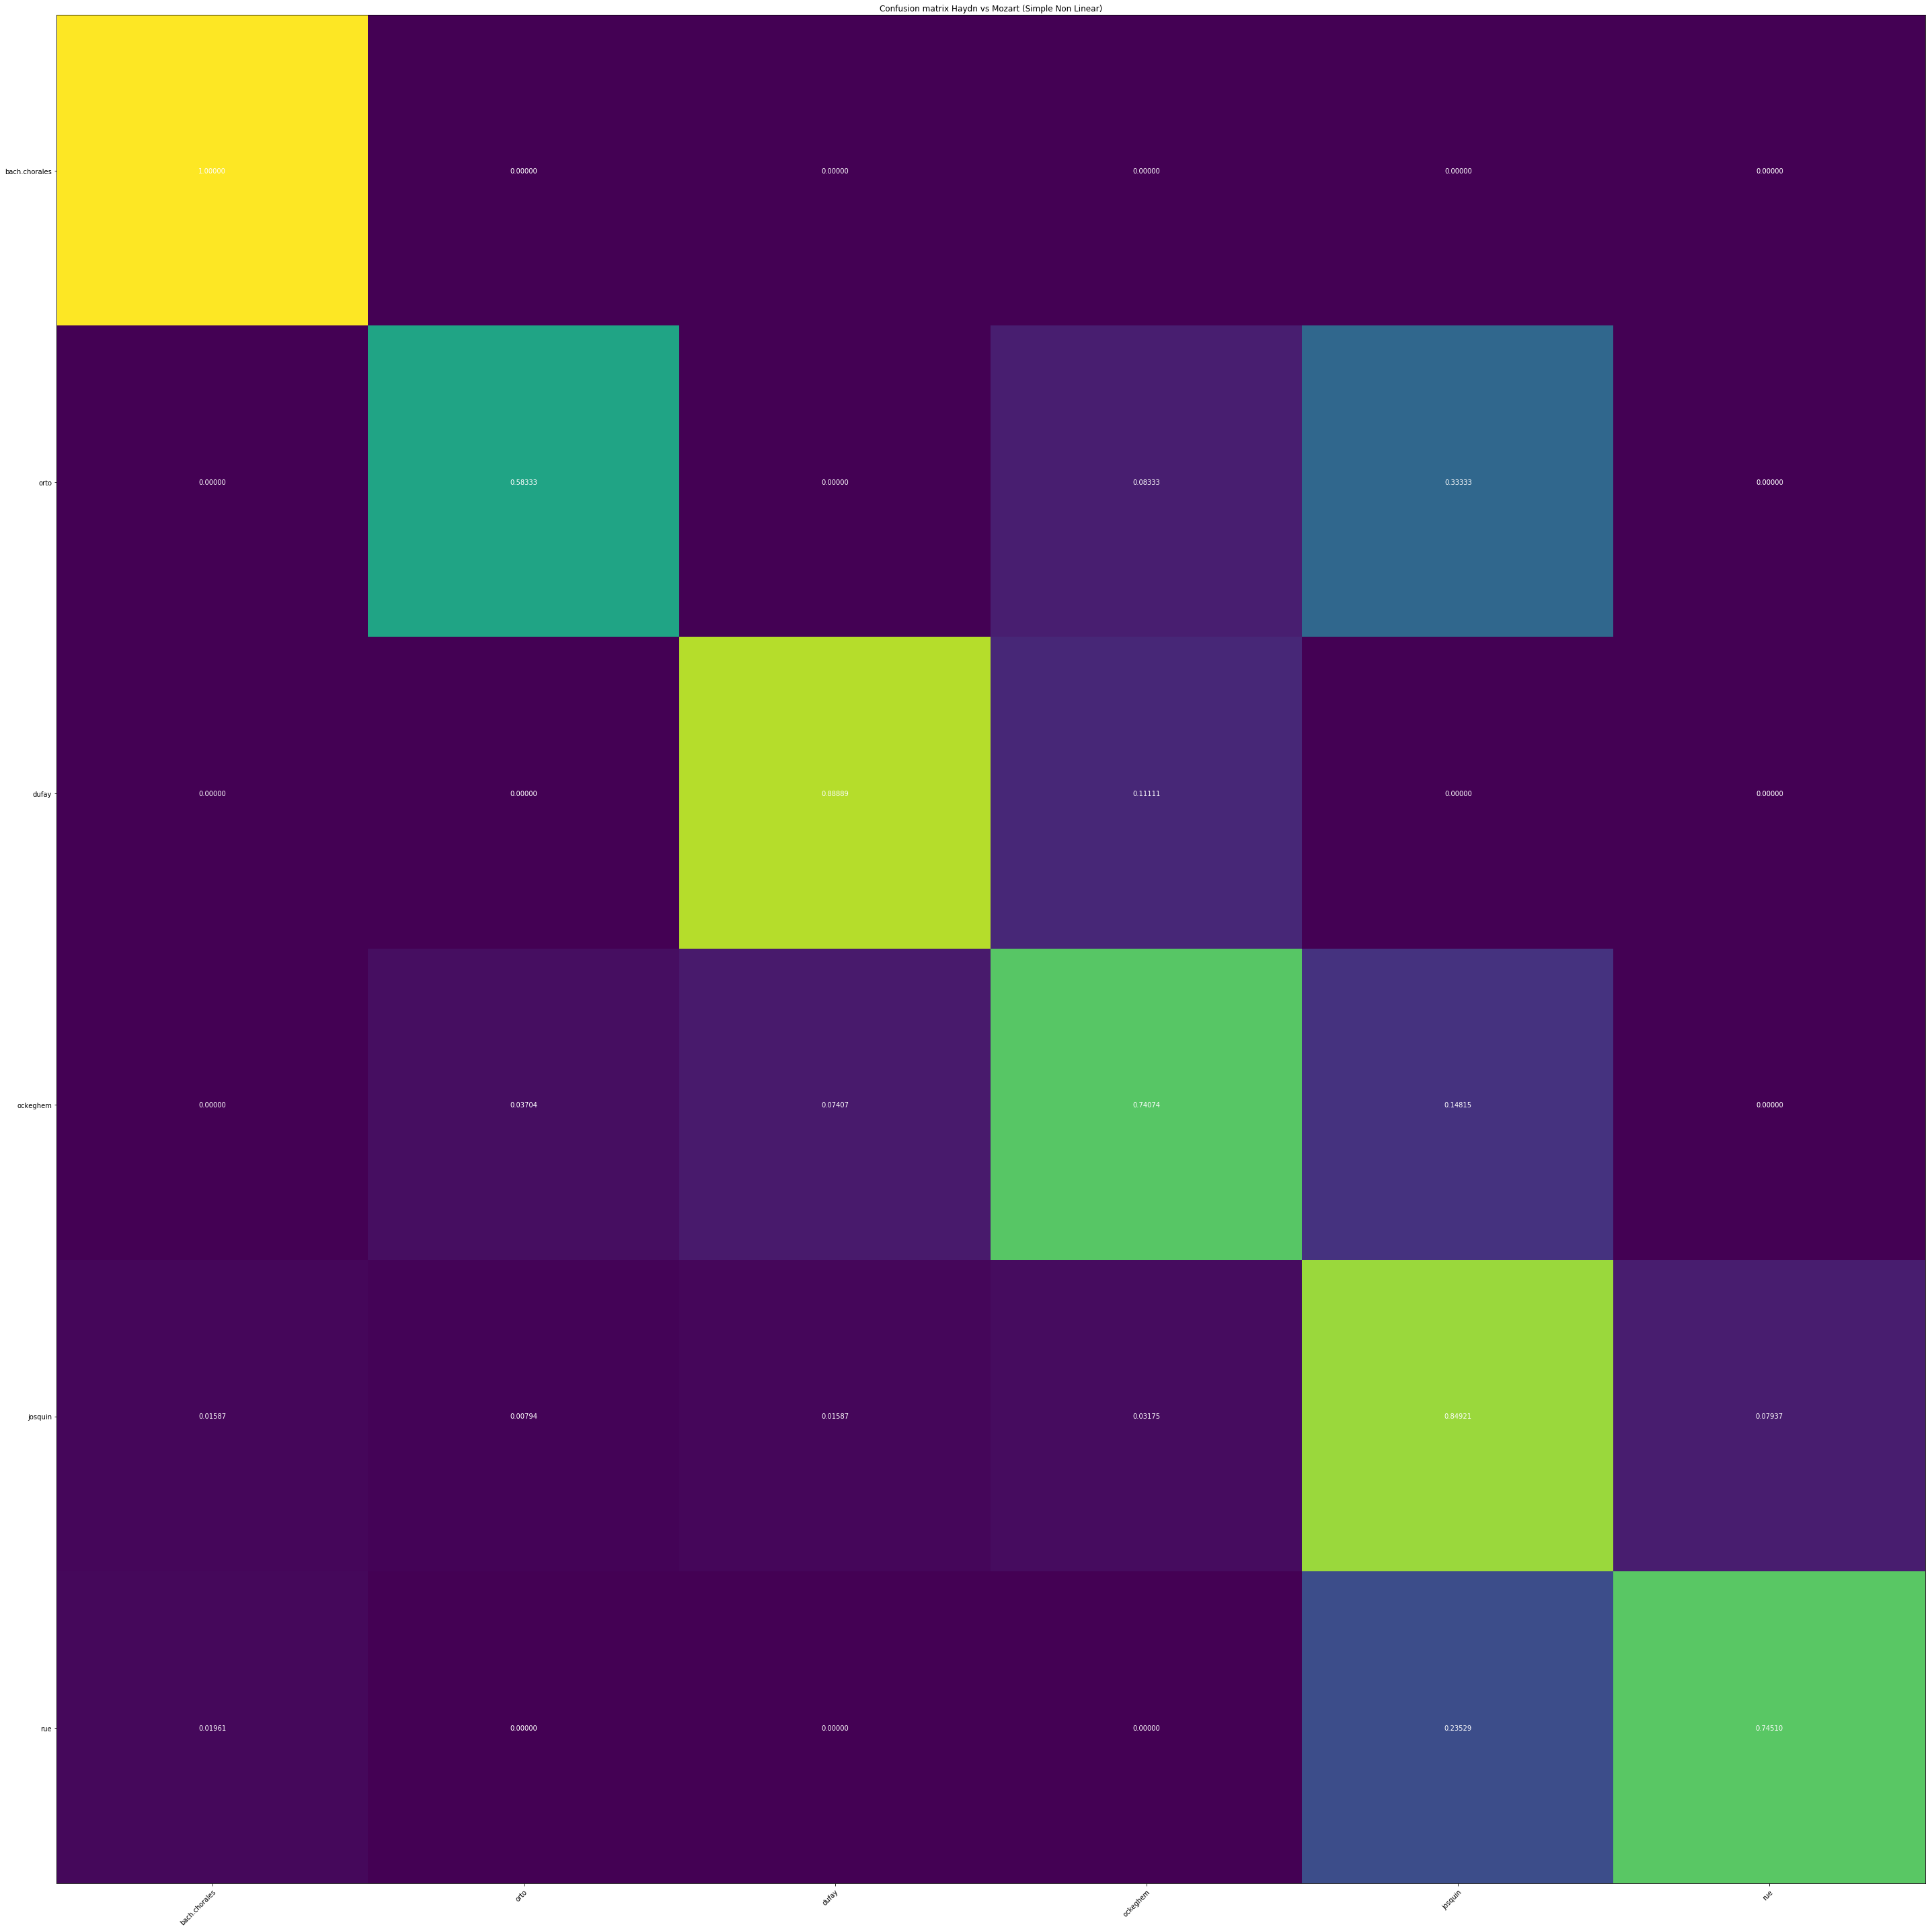

bach.chorales 37 / 37 = 1.0
dufay 3 / 3 = 1.0
josquin 35 / 42 = 0.8333333333333334
ockeghem 7 / 9 = 0.7777777777777778
orto 3 / 4 = 0.75
rue 14 / 17 = 0.8235294117647058
99 112 0.8839285714285714
---------------------------------------------
---------------------------------------------
Fold 3
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
6.00    6.25    0       6

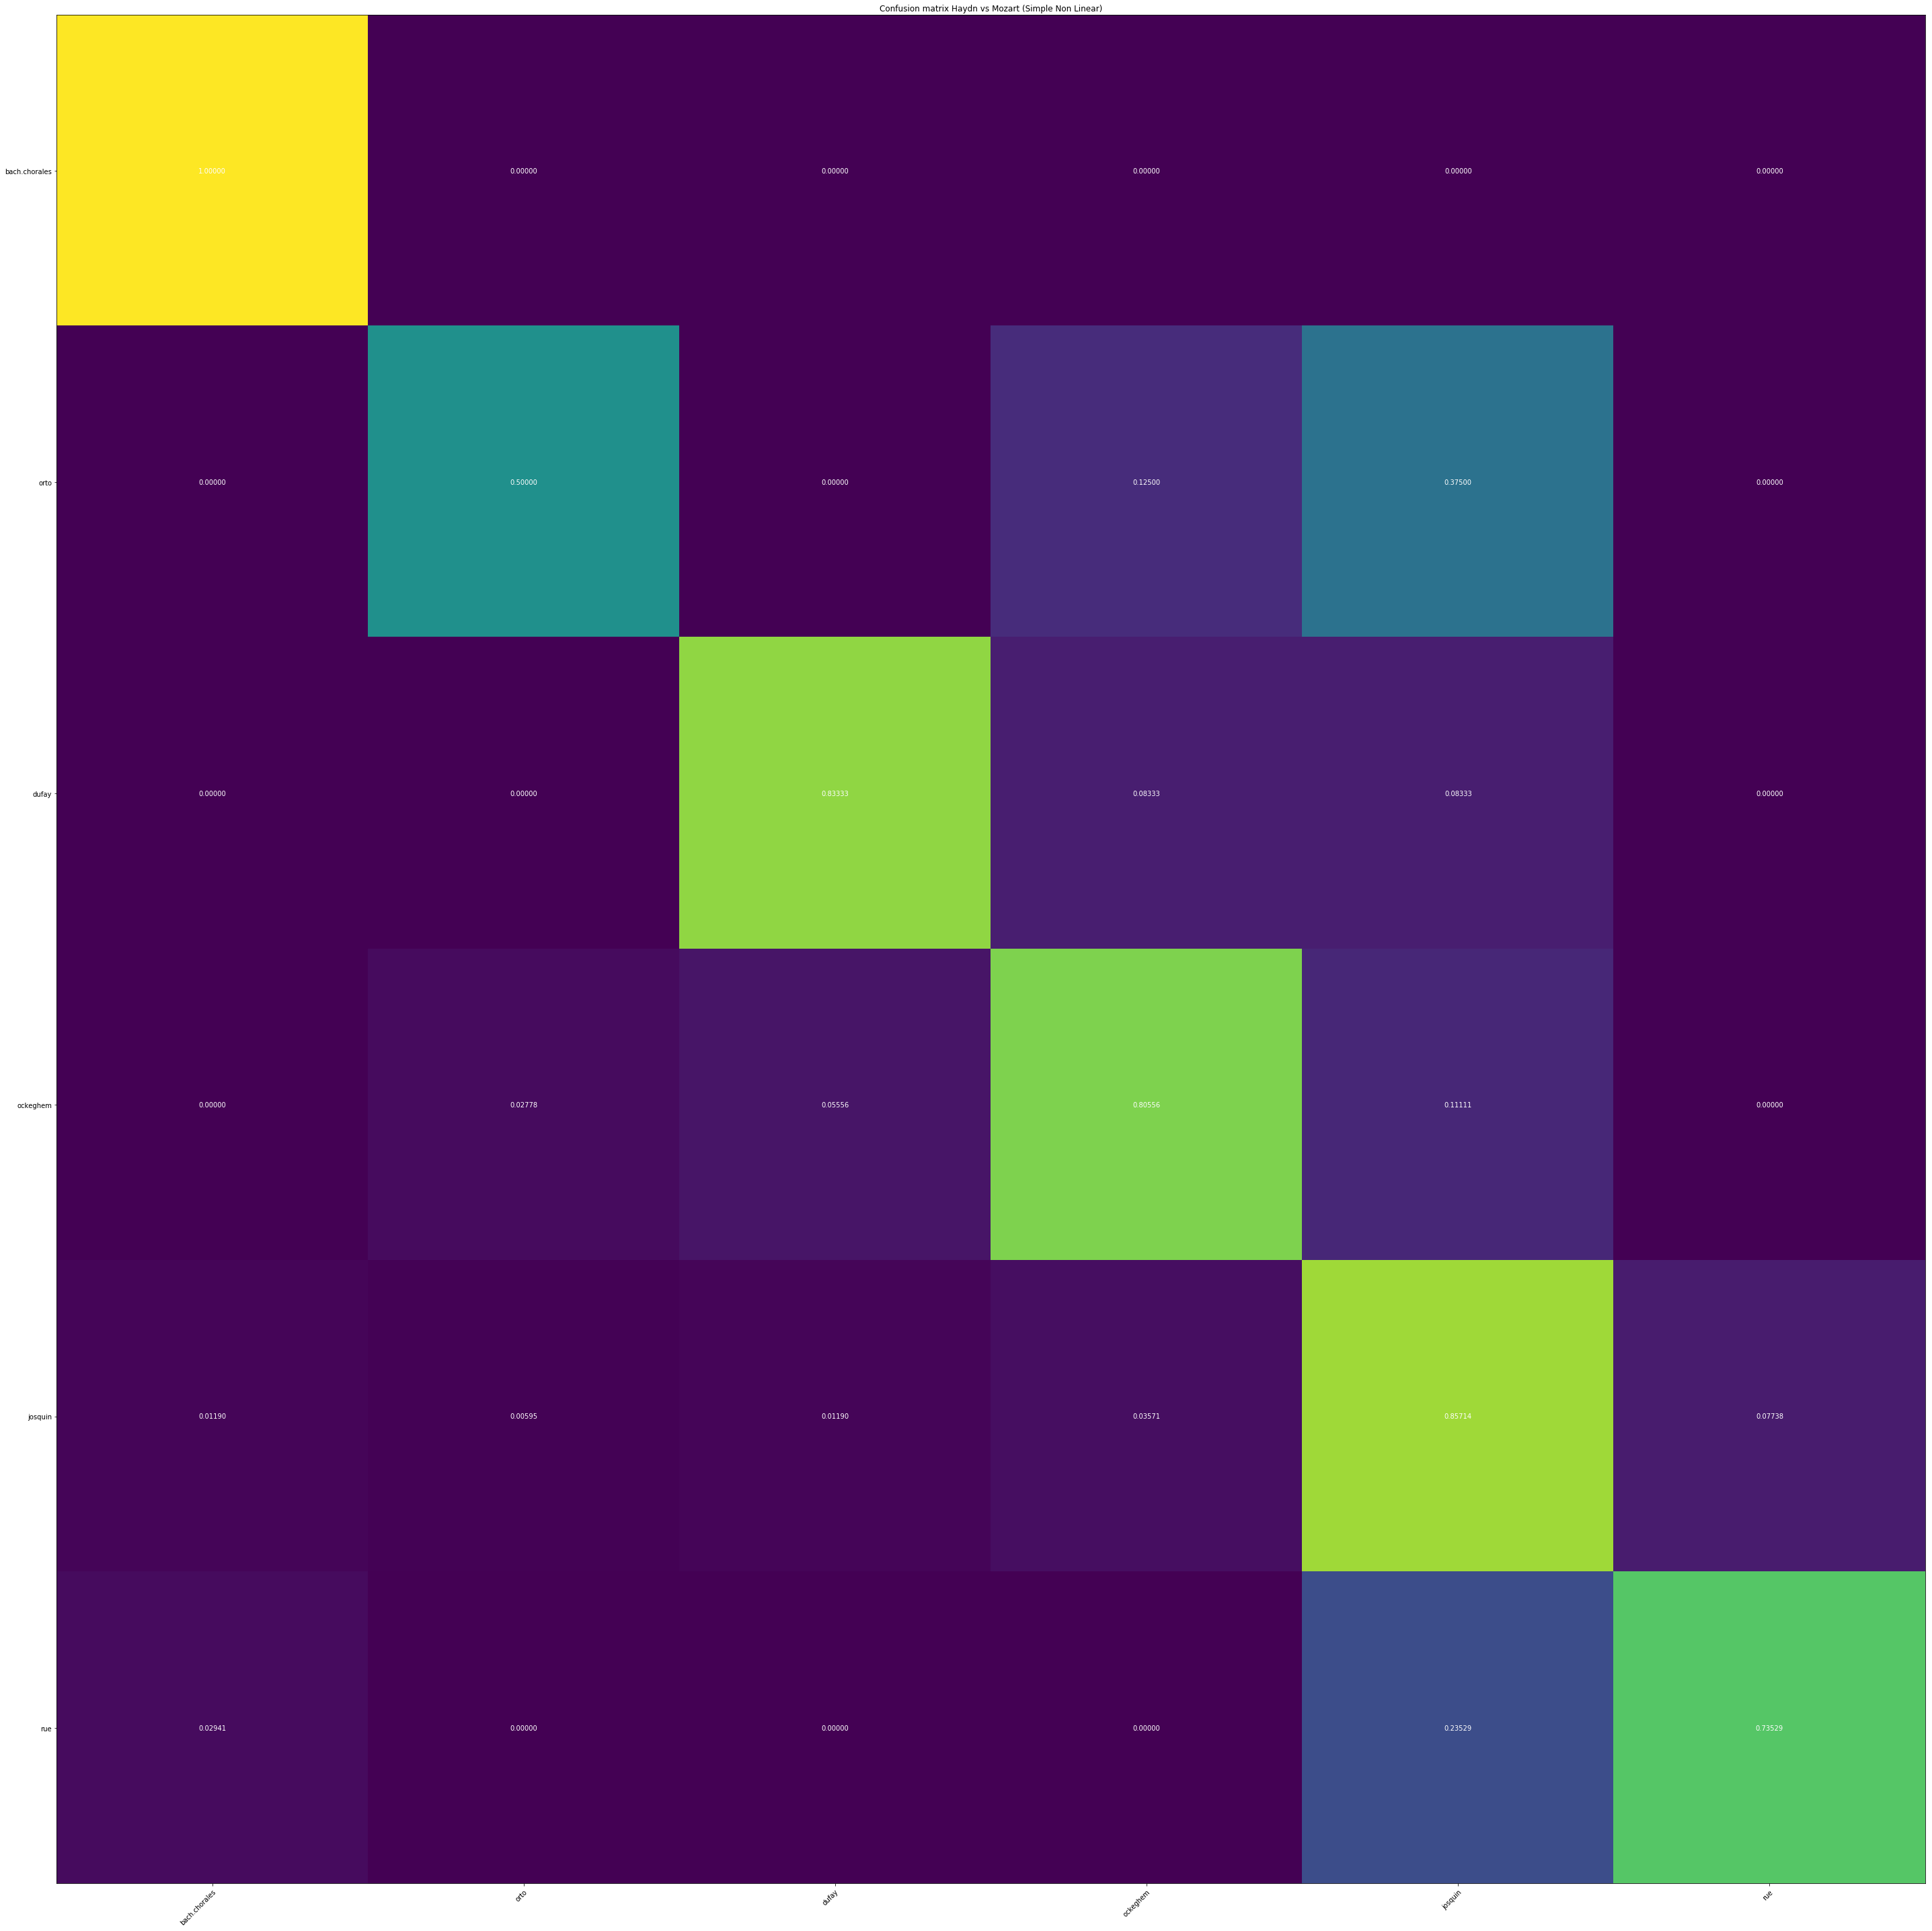

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 37 / 42 = 0.8809523809523809
ockeghem 9 / 9 = 1.0
orto 1 / 4 = 0.25
rue 12 / 17 = 0.7058823529411765
98 112 0.875
---------------------------------------------
---------------------------------------------
Fold 4
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
9.00    8.04    0       4.47    4.85  

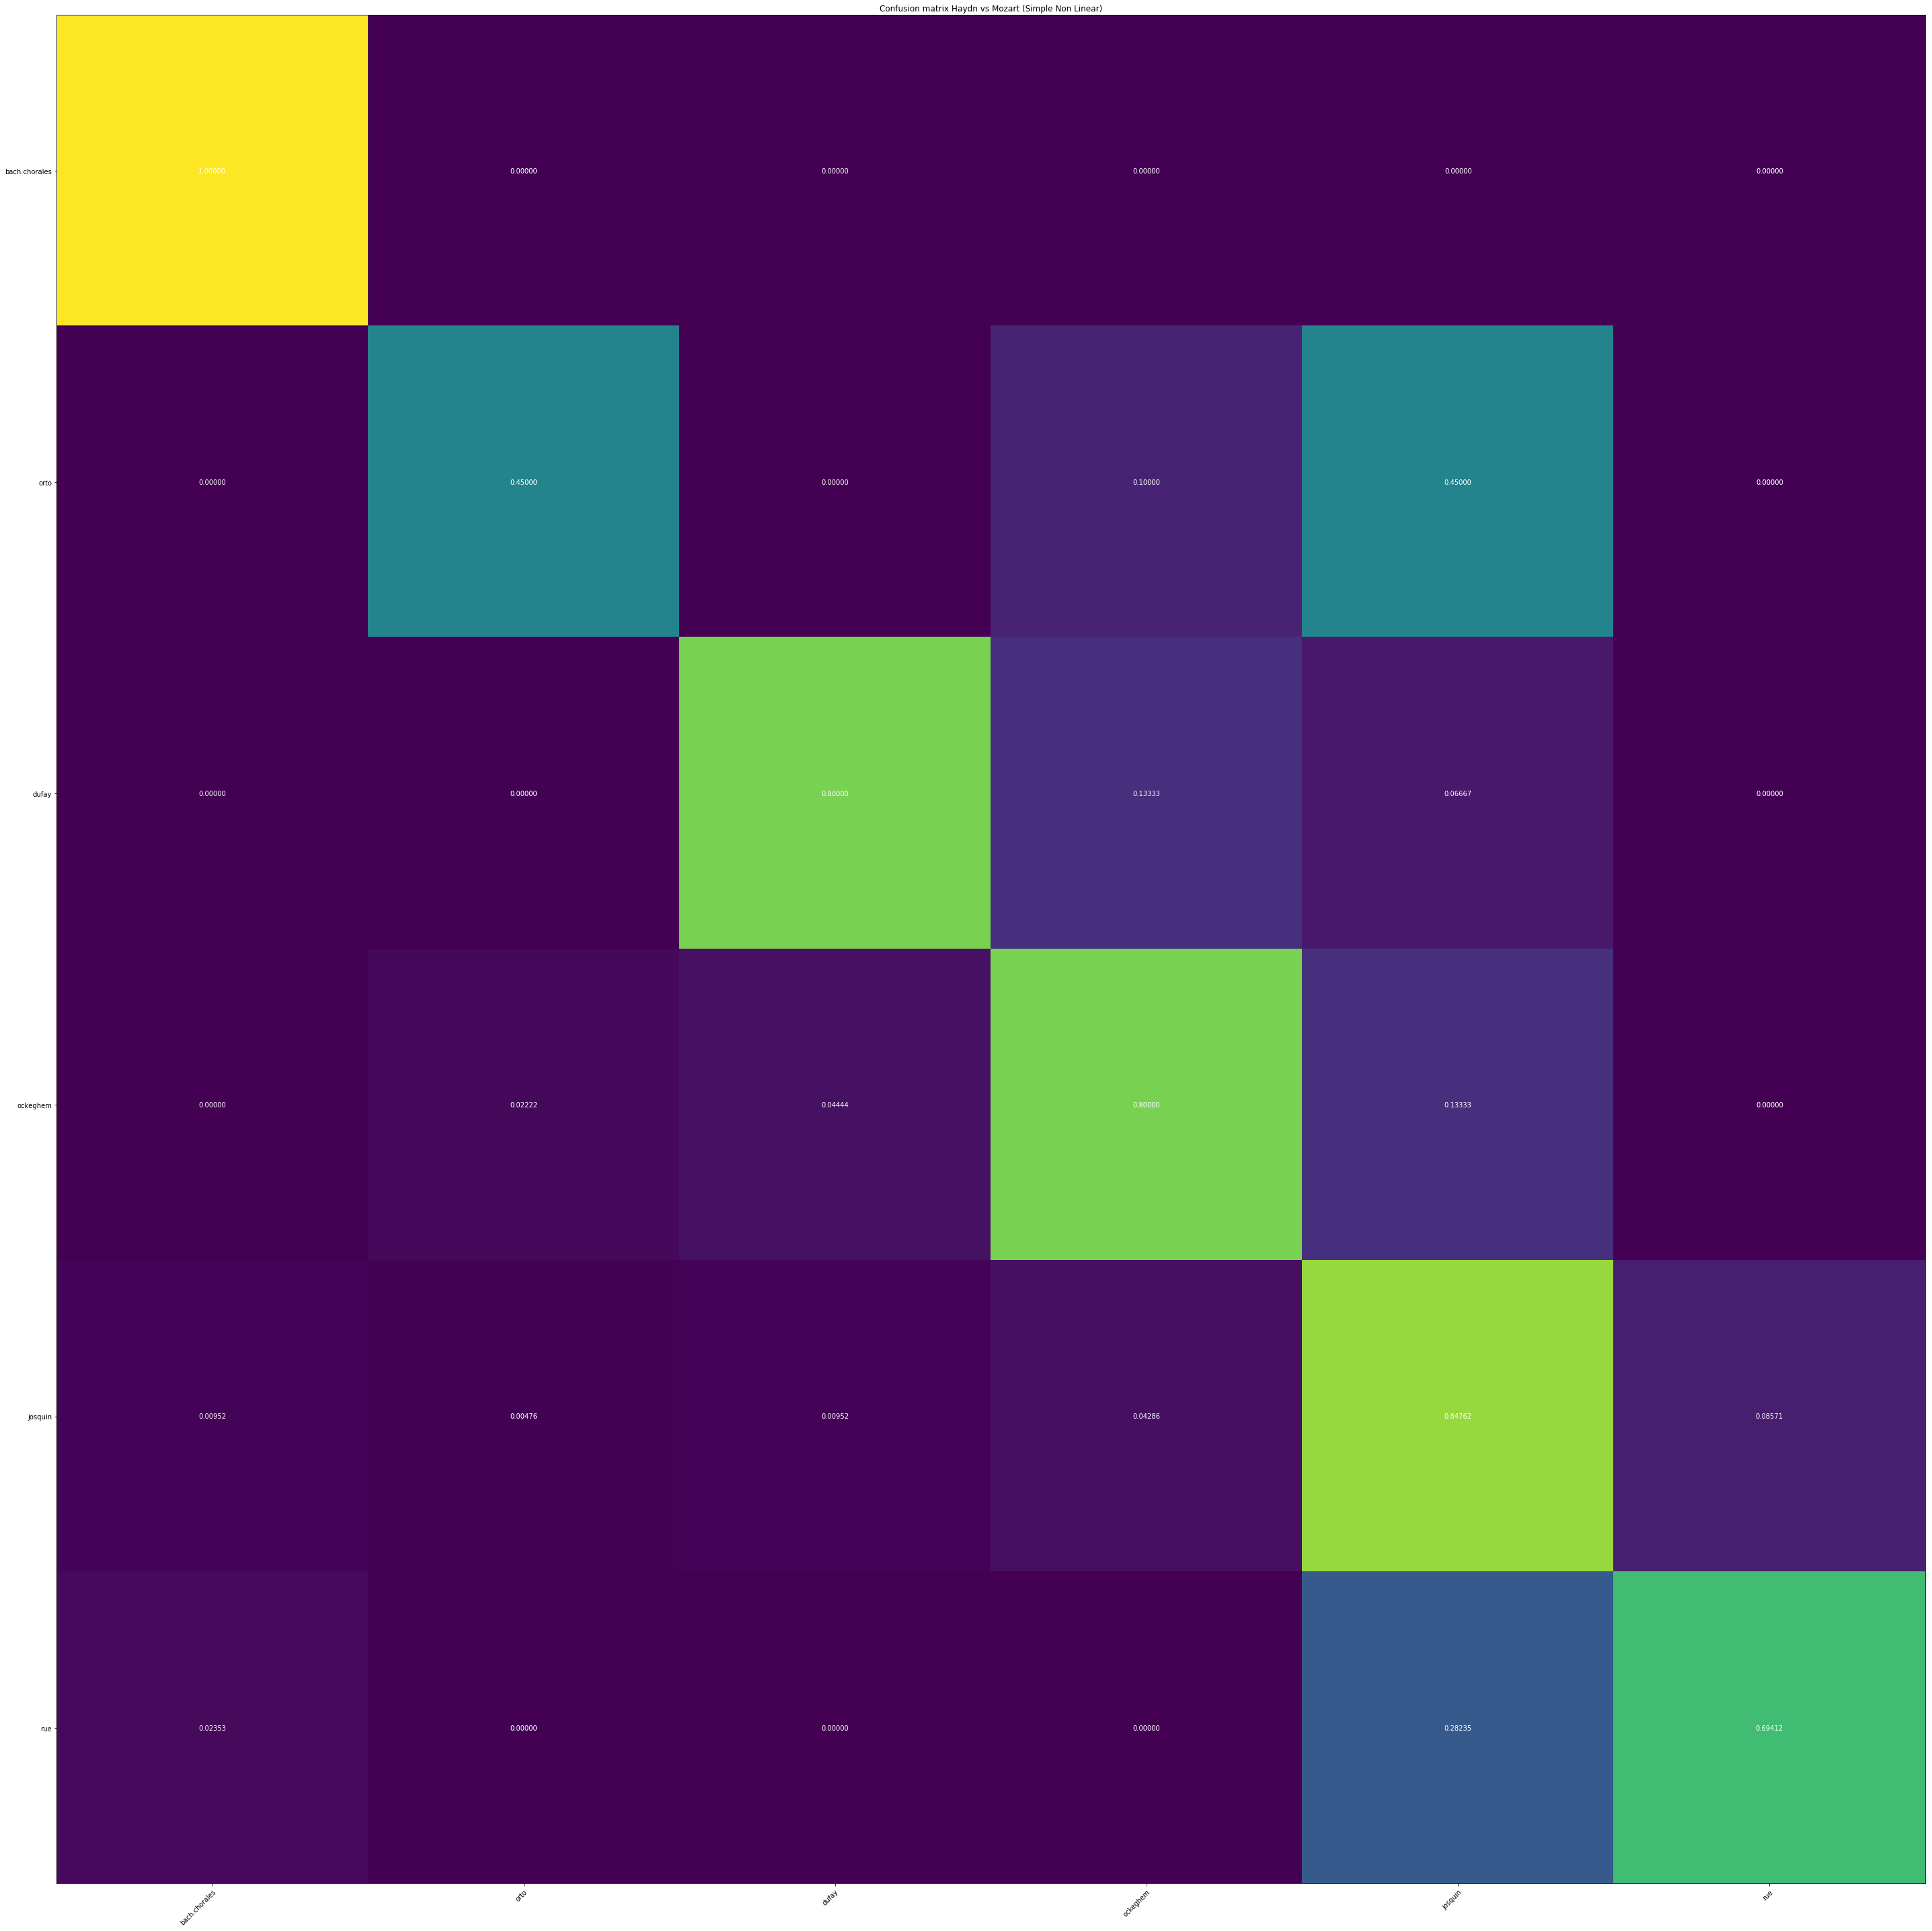

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 34 / 42 = 0.8095238095238095
ockeghem 7 / 9 = 0.7777777777777778
orto 1 / 4 = 0.25
rue 9 / 17 = 0.5294117647058824
90 112 0.8035714285714286
---------------------------------------------
---------------------------------------------
Fold 5
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
8.50    8.0

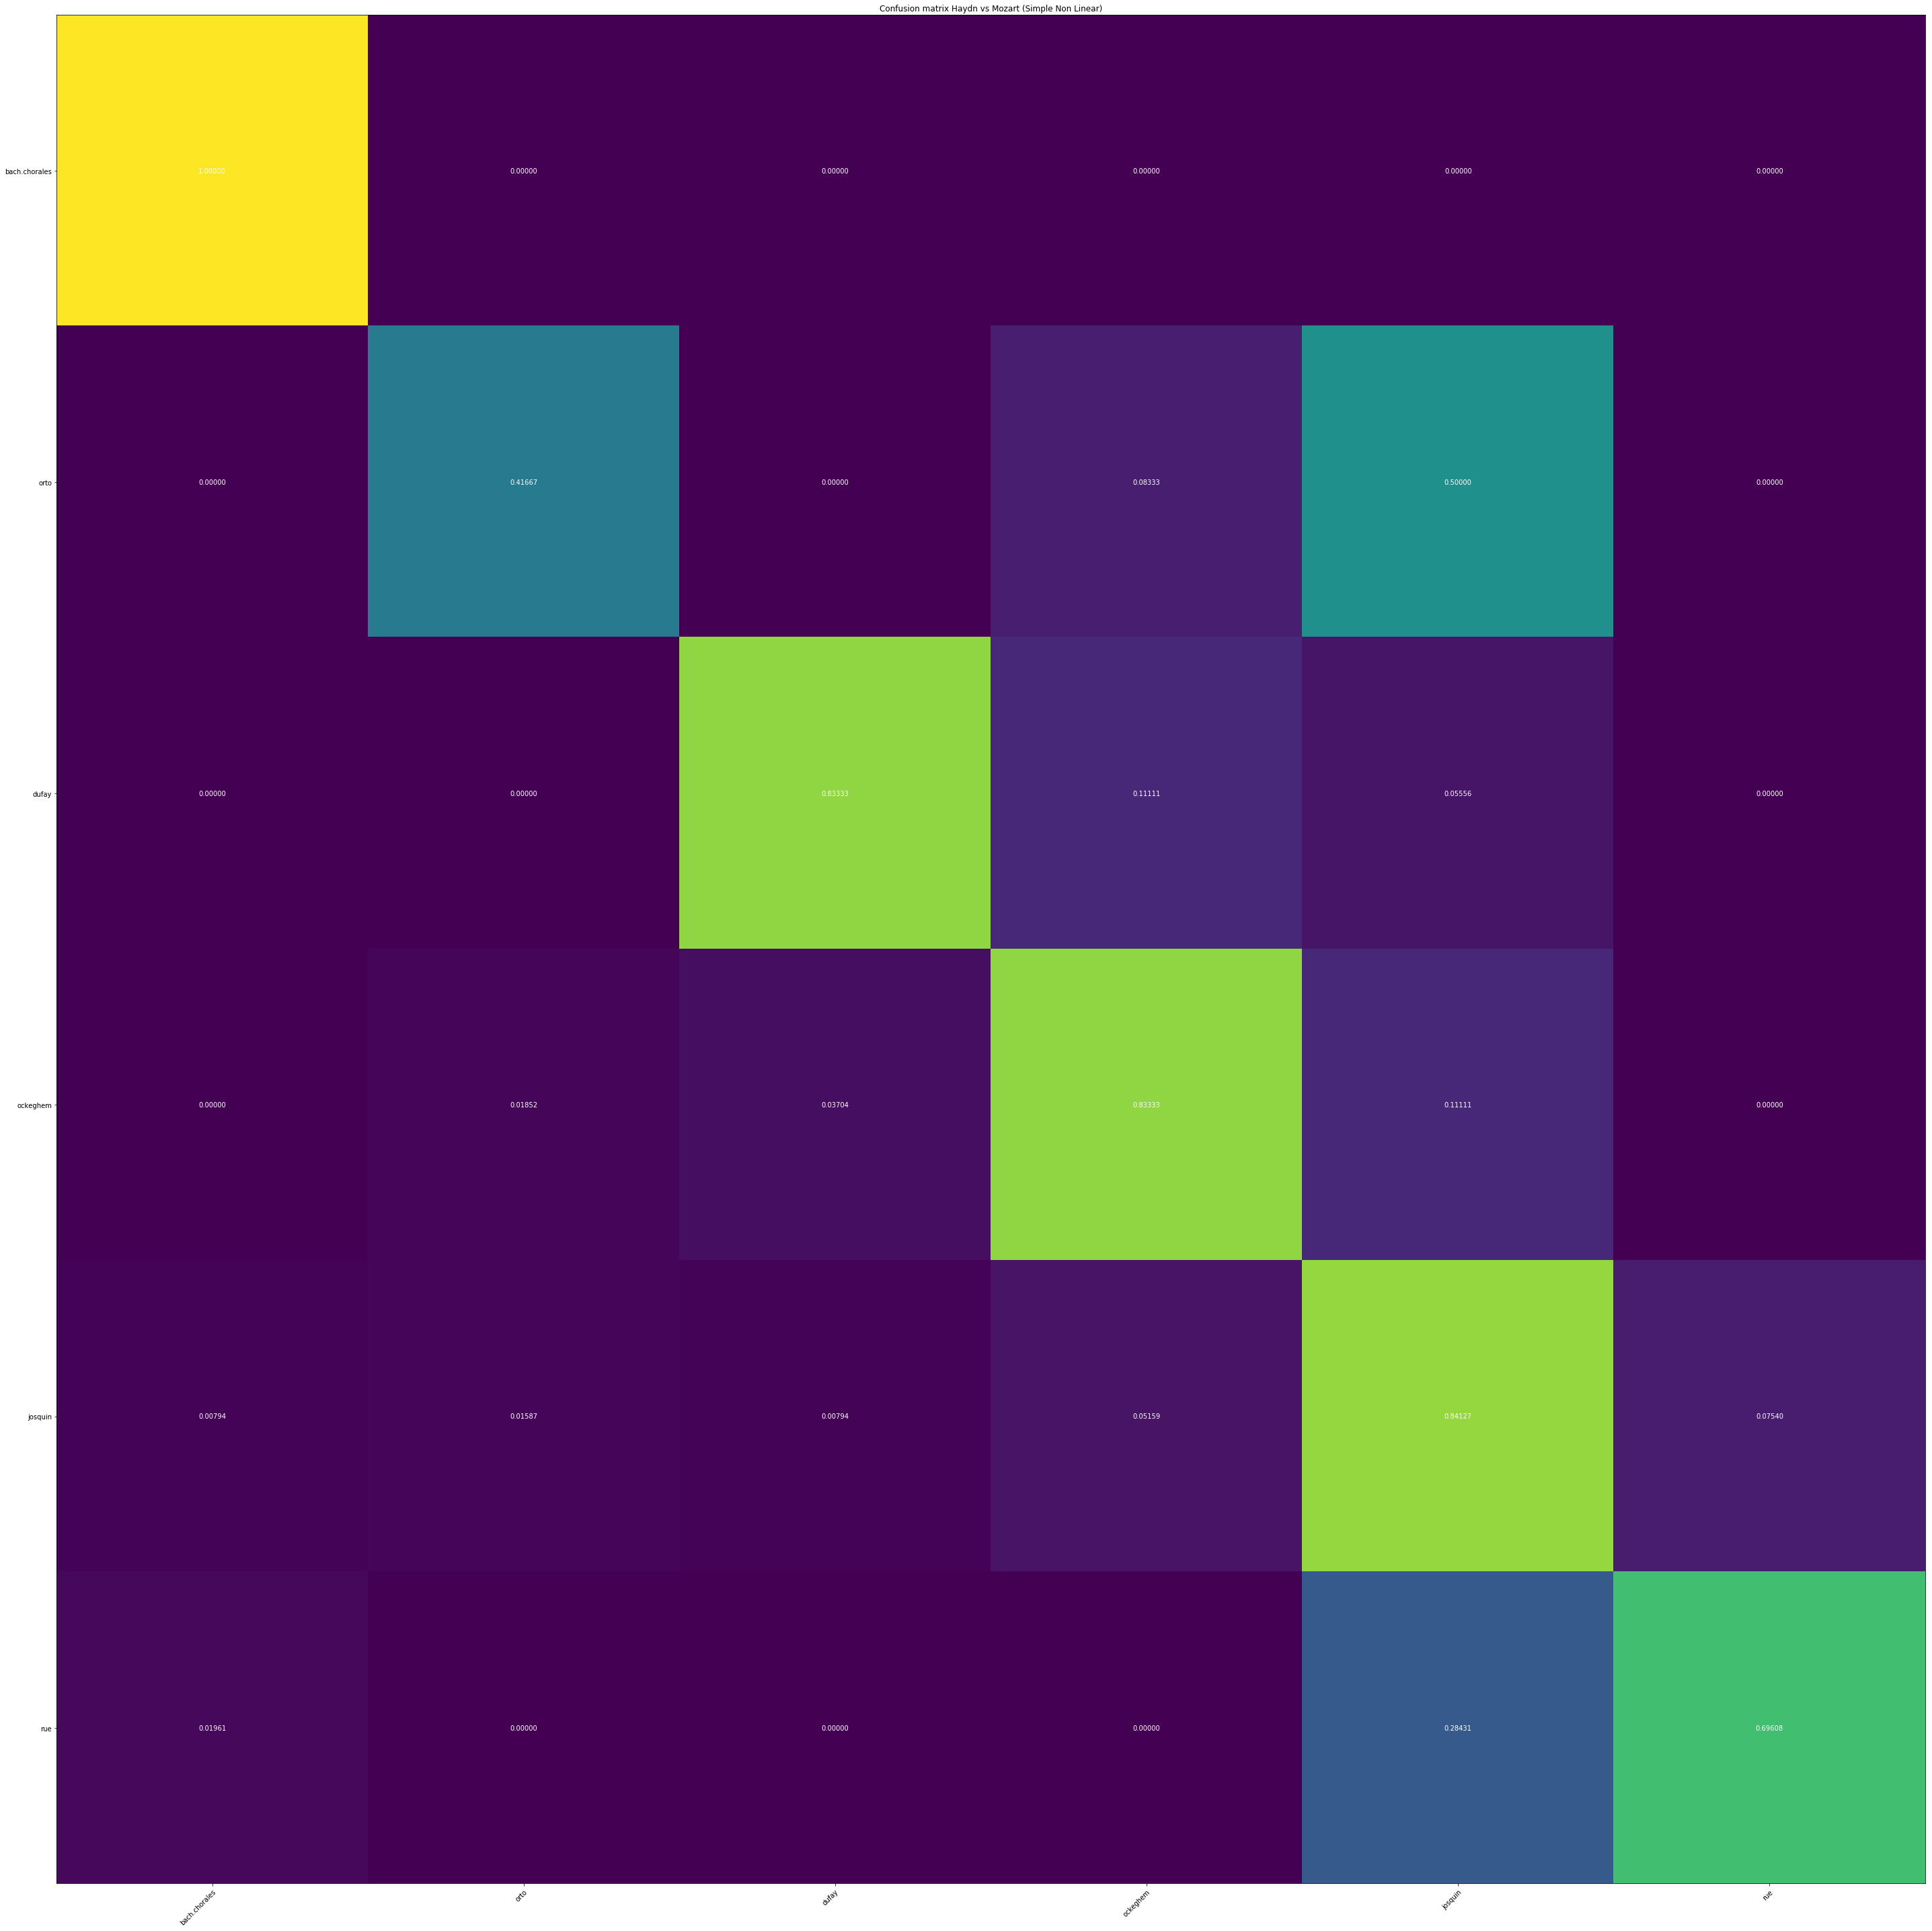

bach.chorales 37 / 37 = 1.0
dufay 3 / 3 = 1.0
josquin 34 / 42 = 0.8095238095238095
ockeghem 9 / 9 = 1.0
orto 1 / 4 = 0.25
rue 12 / 17 = 0.7058823529411765
96 112 0.8571428571428571
---------------------------------------------
---------------------------------------------
Fold 6
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
3.00    2.68    0       4.24    3.76    

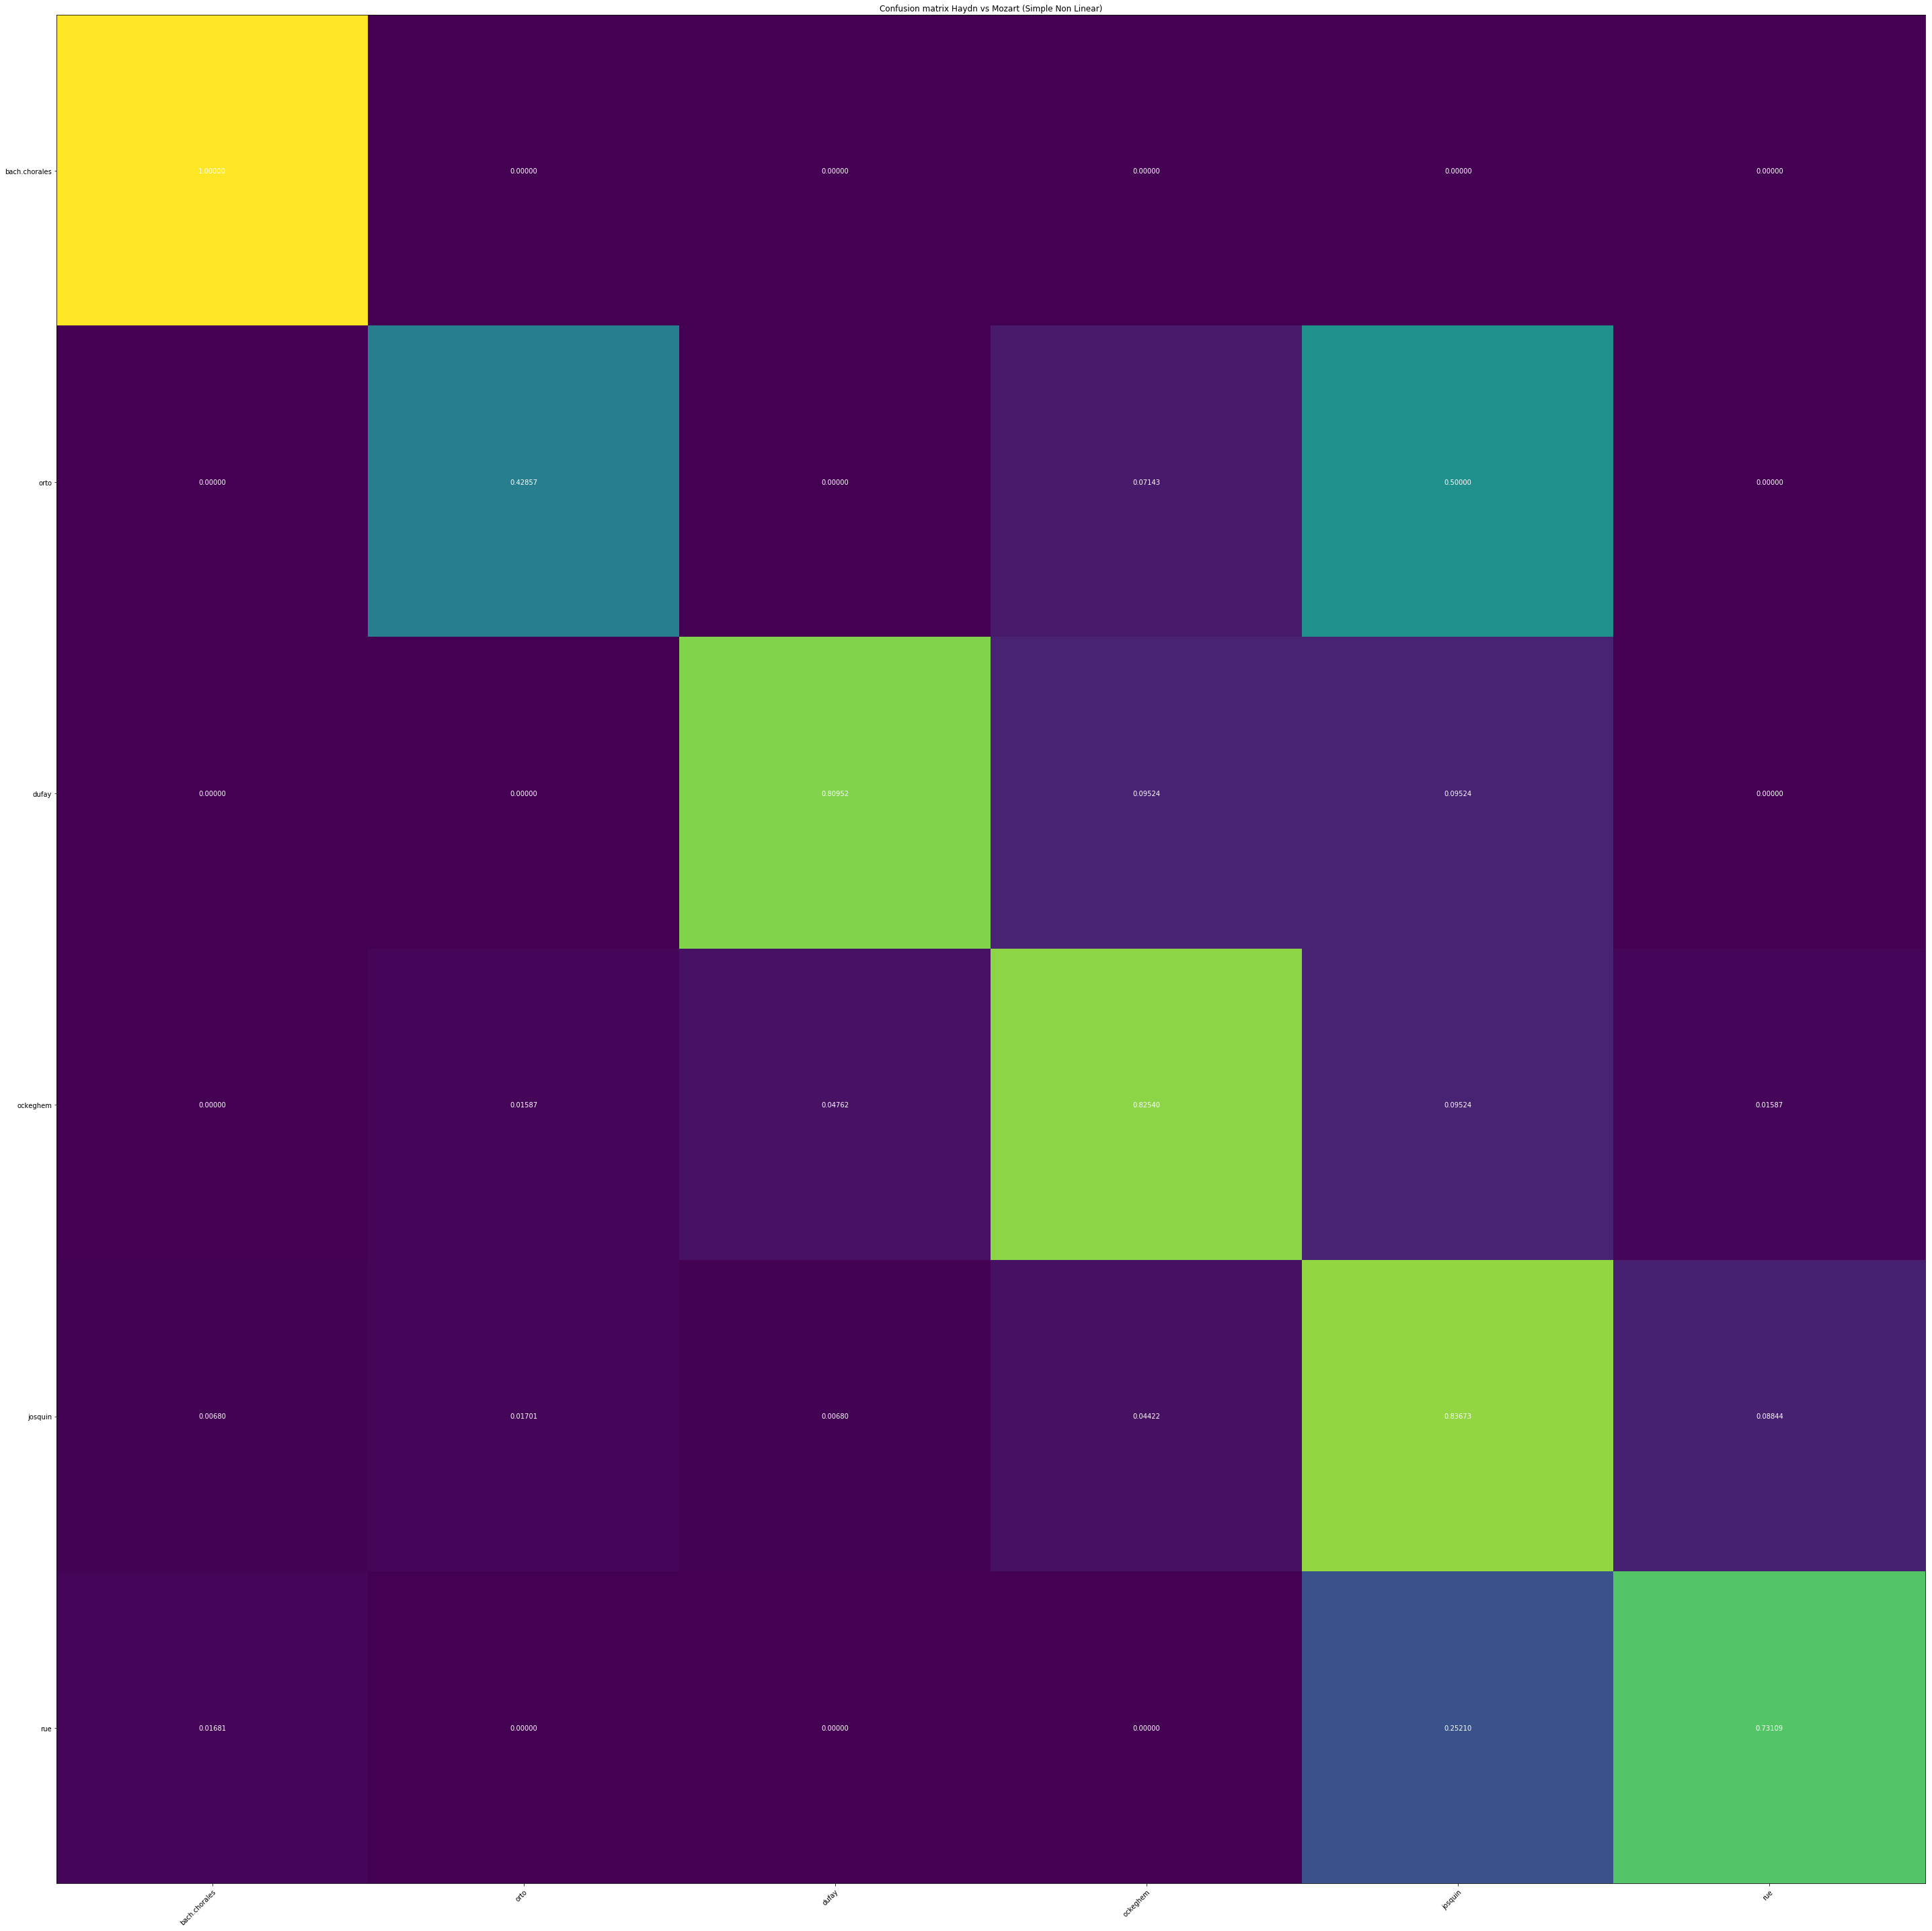

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 34 / 42 = 0.8095238095238095
ockeghem 7 / 9 = 0.7777777777777778
orto 2 / 4 = 0.5
rue 16 / 17 = 0.9411764705882353
98 112 0.875
---------------------------------------------
---------------------------------------------
Fold 7
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 29 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
40.00   39.29   0       

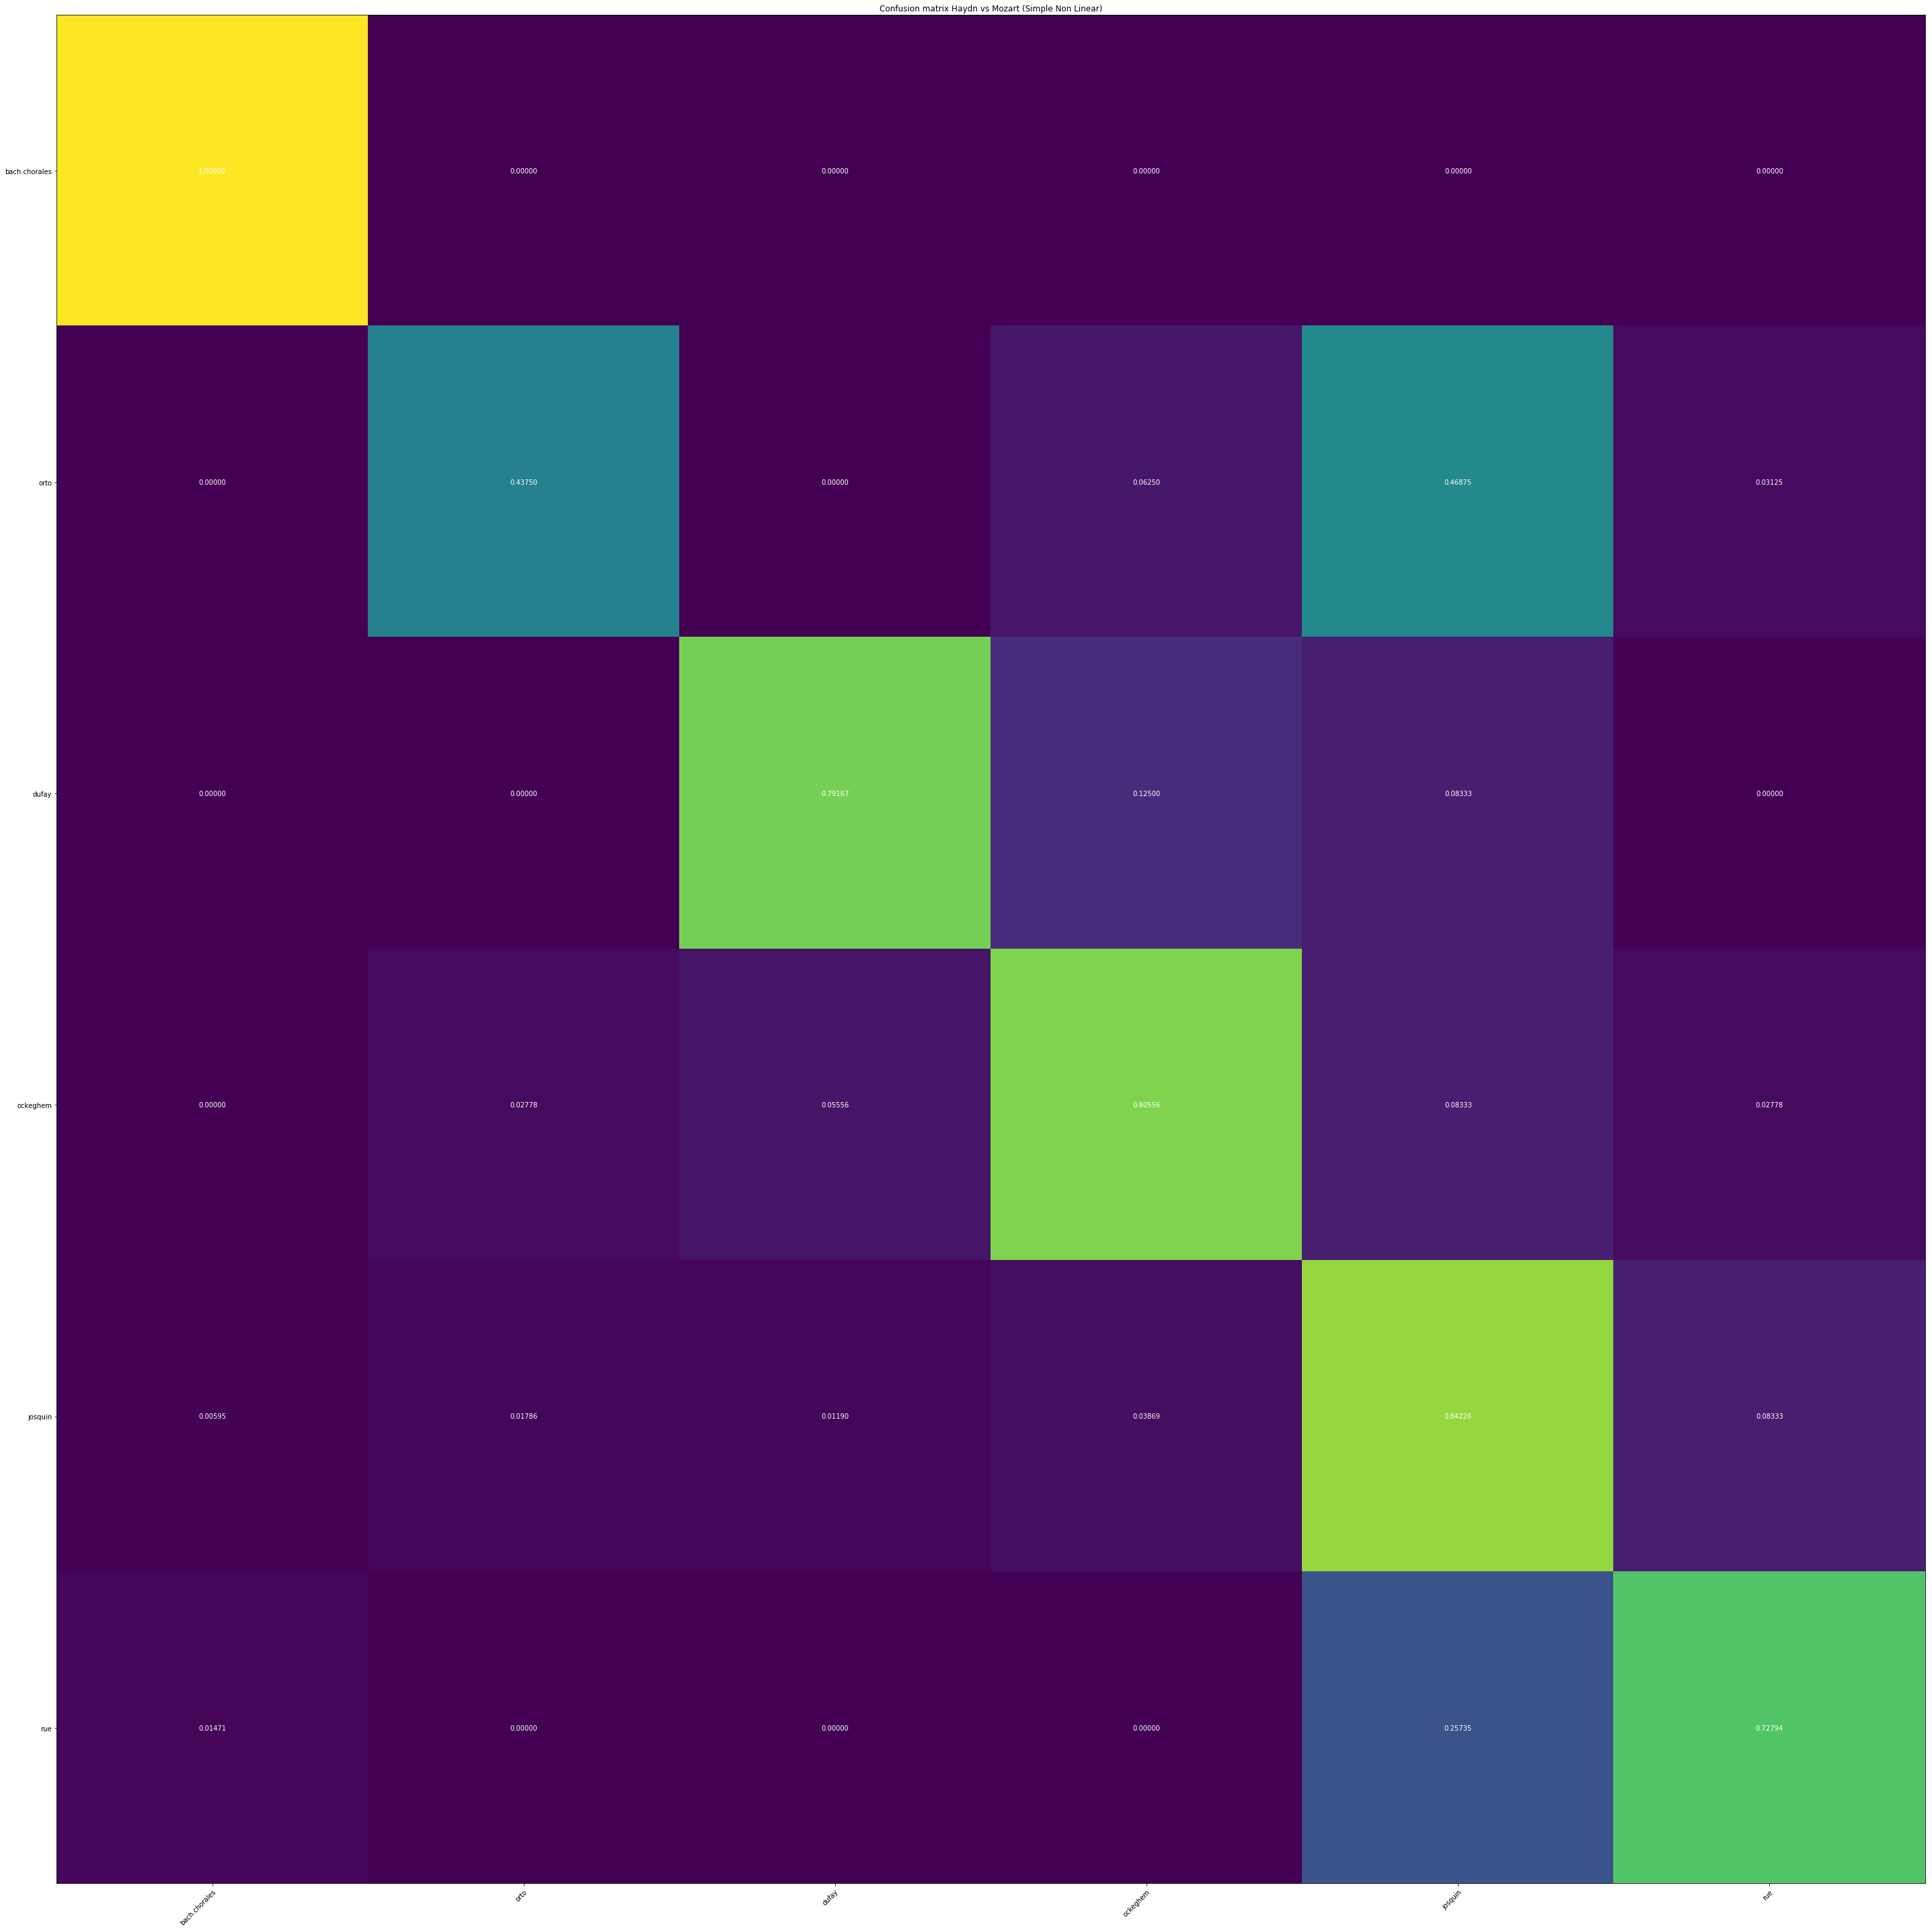

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 37 / 42 = 0.8809523809523809
ockeghem 6 / 9 = 0.6666666666666666
orto 2 / 4 = 0.5
rue 12 / 17 = 0.7058823529411765
96 112 0.8571428571428571
---------------------------------------------
---------------------------------------------
Fold 8
len validation_ids 400
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 28 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
8.50    10.

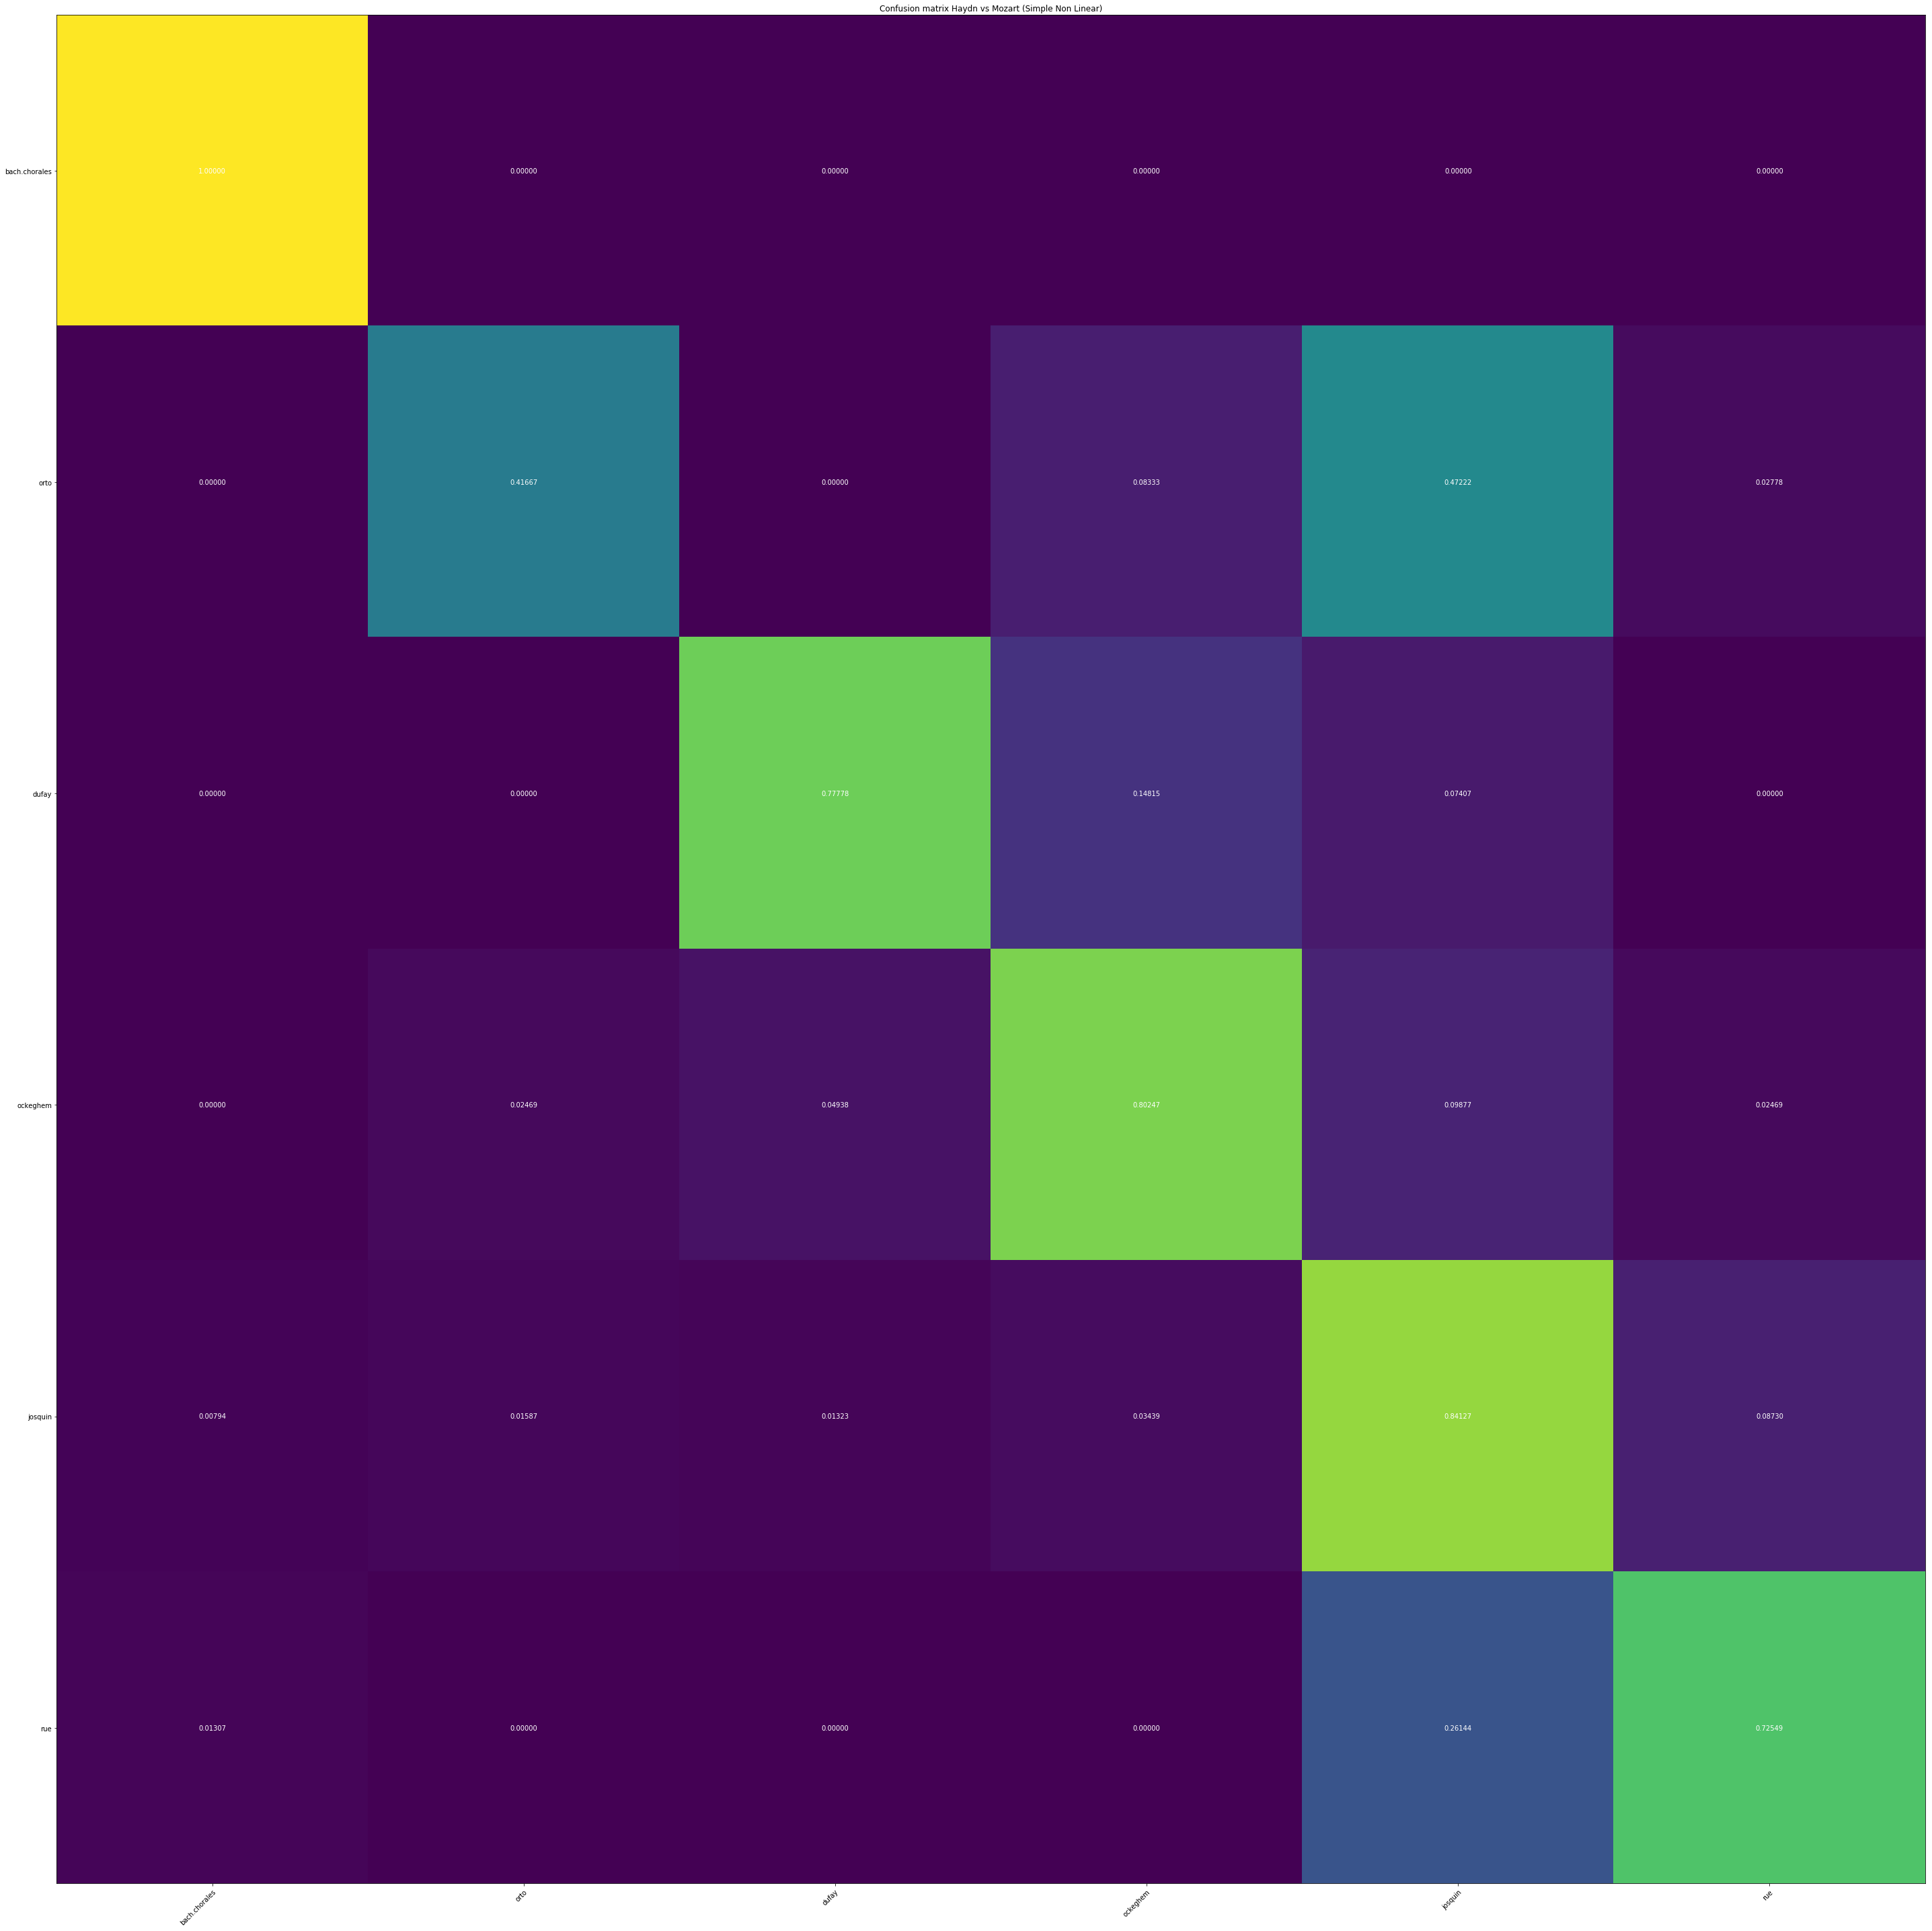

bach.chorales 37 / 37 = 1.0
dufay 2 / 3 = 0.6666666666666666
josquin 35 / 42 = 0.8333333333333334
ockeghem 7 / 9 = 0.7777777777777778
orto 1 / 4 = 0.25
rue 12 / 17 = 0.7058823529411765
94 112 0.8392857142857143
---------------------------------------------
---------------------------------------------
Fold 9
len validation_ids 246
len test_ids 400
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([64, 1, 1, 6, 39]) (14976)
wnotes2 torch.Size([512, 64, 1]) (32768)
wdur torch.Size([512, 330, 1]) (168960)
wtop torch.Size([512, 6]) (3072)
wnotesm torch.Size([256, 78, 1, 3]) (59904)
wdurationm torch.Size([256, 55, 1, 3]) (42240)
w2m torch.Size([256, 256, 1, 3]) (196608)
wtopm torch.Size([256, 6]) (1536)
bias torch.Size([6]) (6)
Initialized graph with 520070 parameters
Initiating optimizer, 28 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
8.00    8.

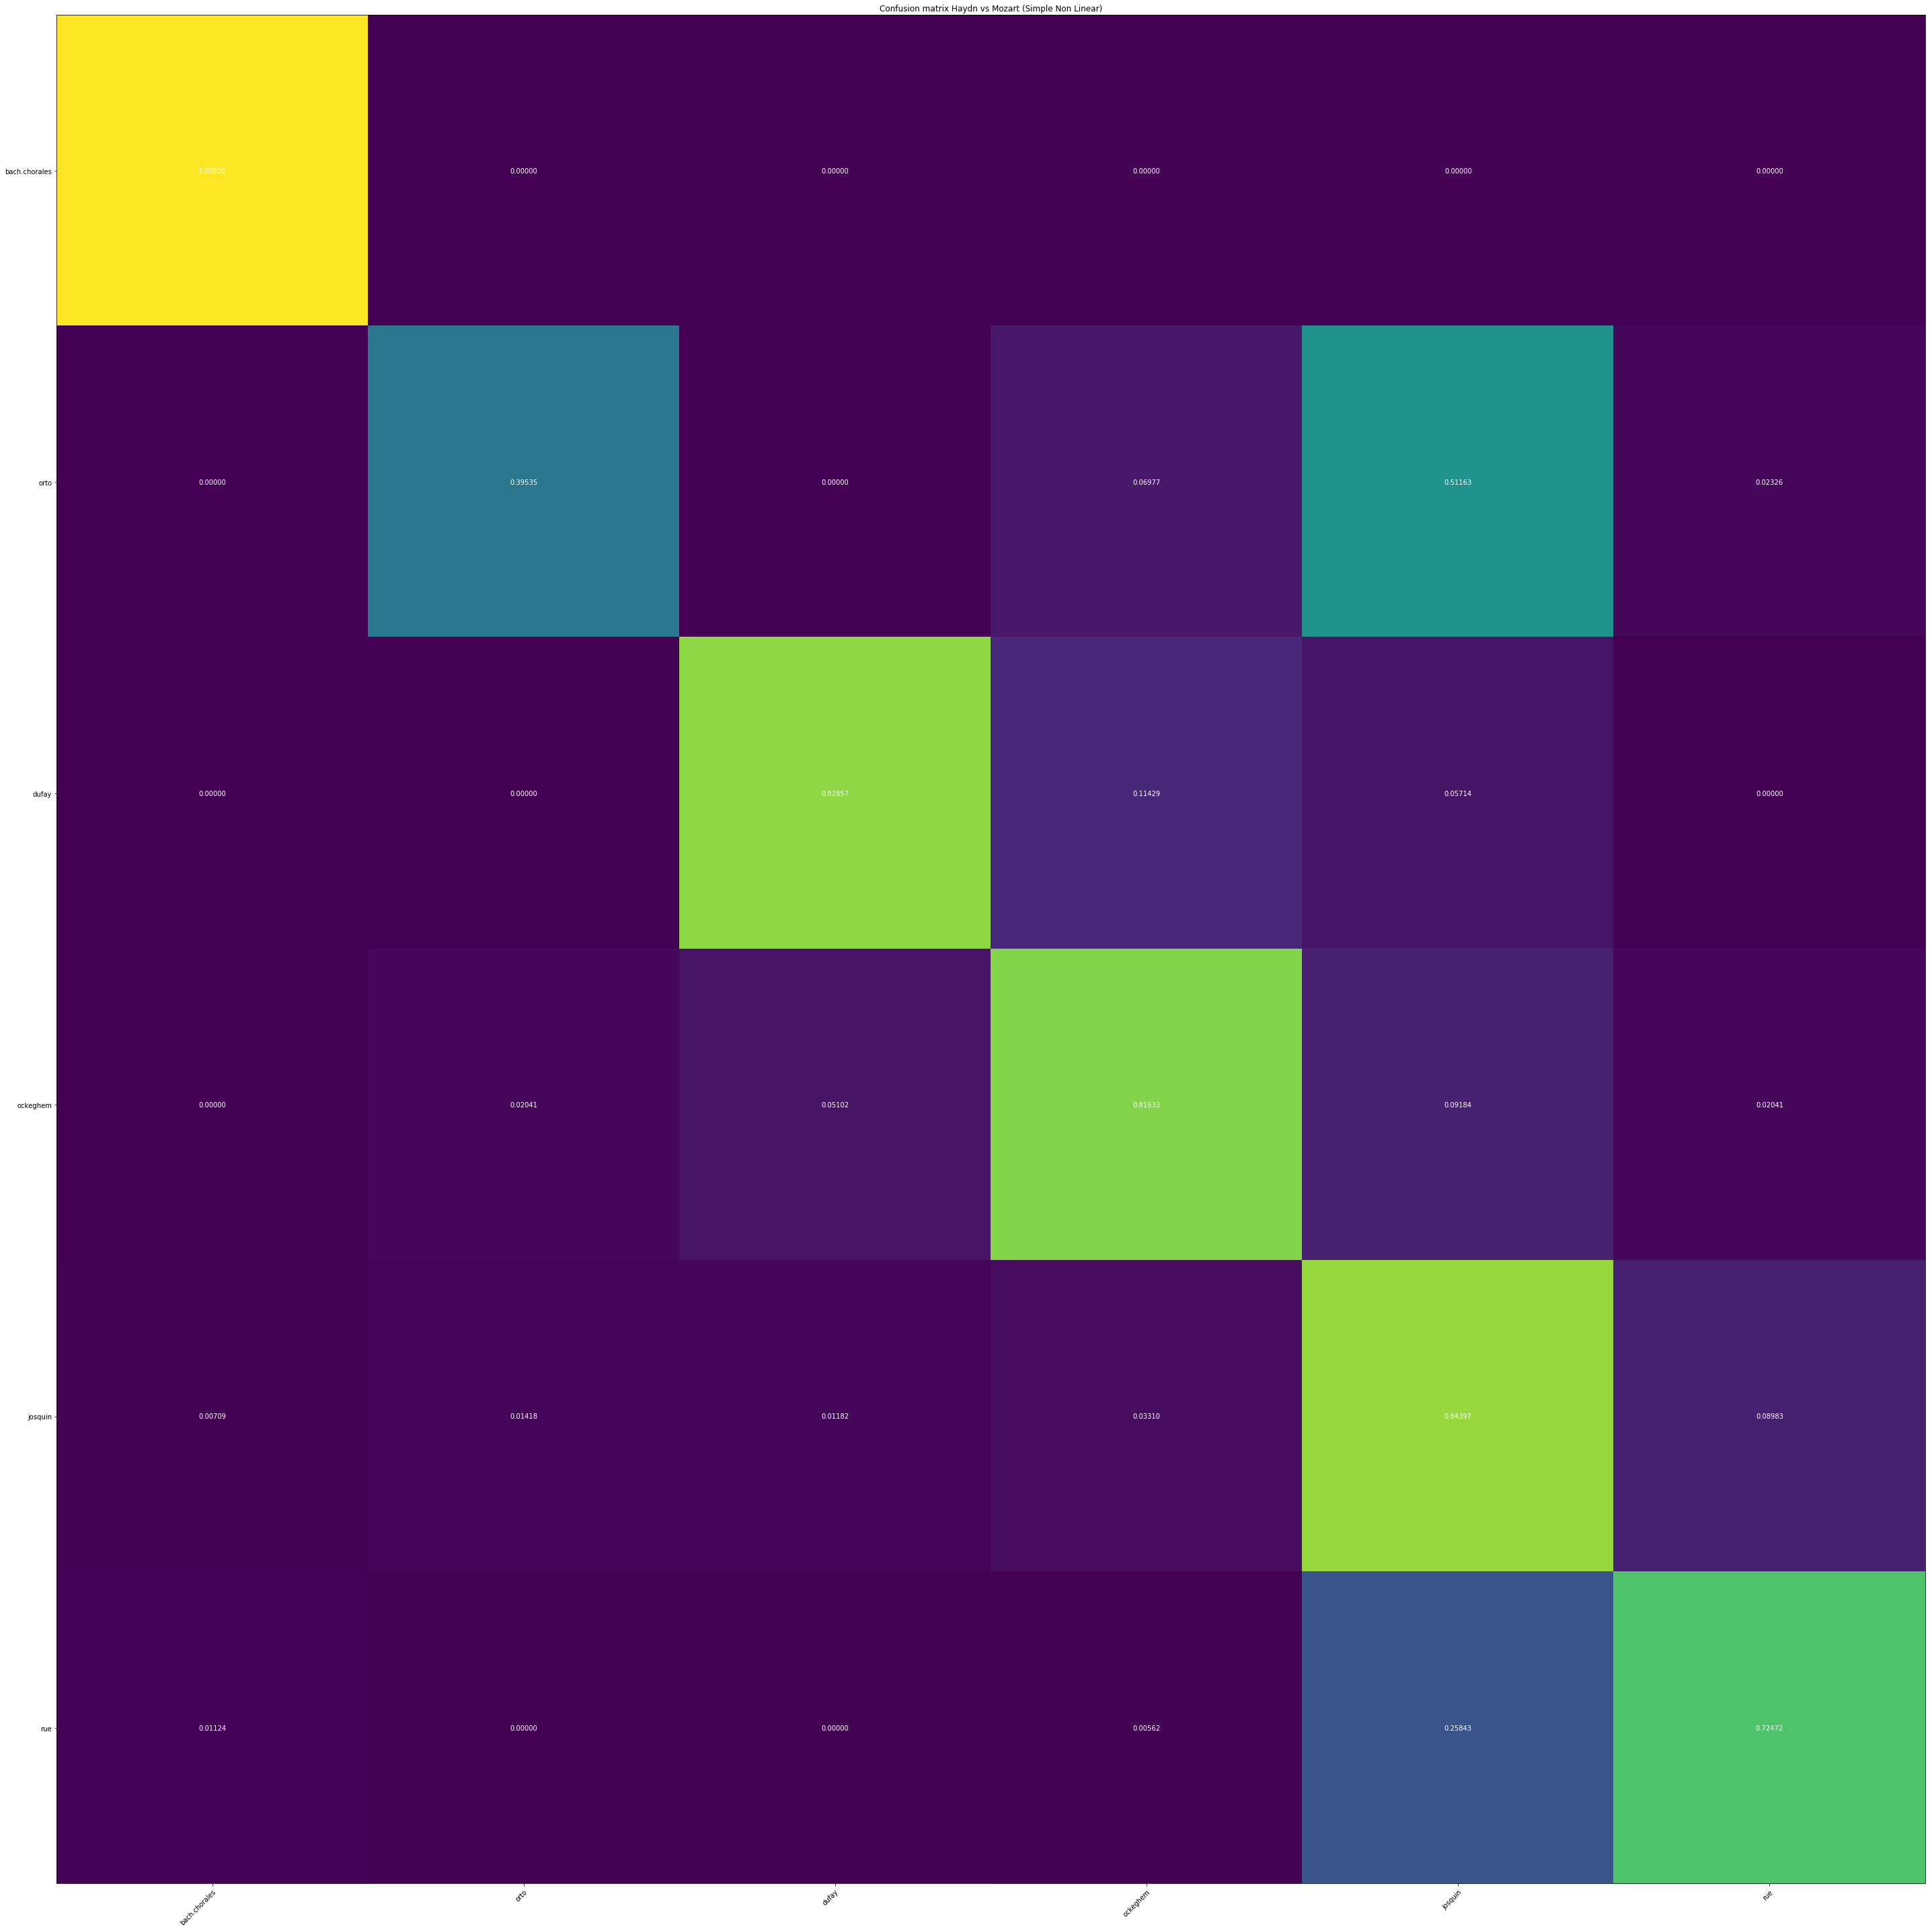

bach.chorales 37 / 37 = 1.0
dufay 8 / 8 = 1.0
josquin 39 / 45 = 0.8666666666666667
ockeghem 15 / 17 = 0.8823529411764706
orto 2 / 7 = 0.2857142857142857
rue 18 / 25 = 0.72
119 139 0.8561151079136691


In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=30, batch_size=32)
validator.run(context, checkpoint_dir=checkpoint_dir)